# Unsupervised Learning - Clustering

## Wstęp

## Import bibliotek

In [1]:
%pip install ucimlrepo
%pip install ydata-profiling
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

In [38]:
random = 42
generate_report = True

## Wczytanie zbioru

In [4]:
# fetch dataset
abalone = fetch_ucirepo(id=1) 

# data (as pandas dataframes)
X = abalone.data.features 
y = abalone.data.targets 

# metadata
print(abalone.metadata) 

# variable information
print(abalone.variables) 

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

## Podział na zbiór treningowy i testowy

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random)

In [6]:
df_to_profile = pd.concat([X_train, y_train], axis=1) 

In [45]:
if generate_report:
    # Generate the profile report
    profile = ProfileReport(df_to_profile)

    # Display the profile report
    profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning:

There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'I'')



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Wnioski z AutoEDA

- Zbiór nie posiada wartości brakujących
- Posiada jedną kolumnę kategoryczną, jest to płeć słuchotki (Uchowca) - rodzina ślimaków morskich - rozkład równomierny
- Wszystkie pozostałe są numeryczne
- Height posiada wartości odstające: 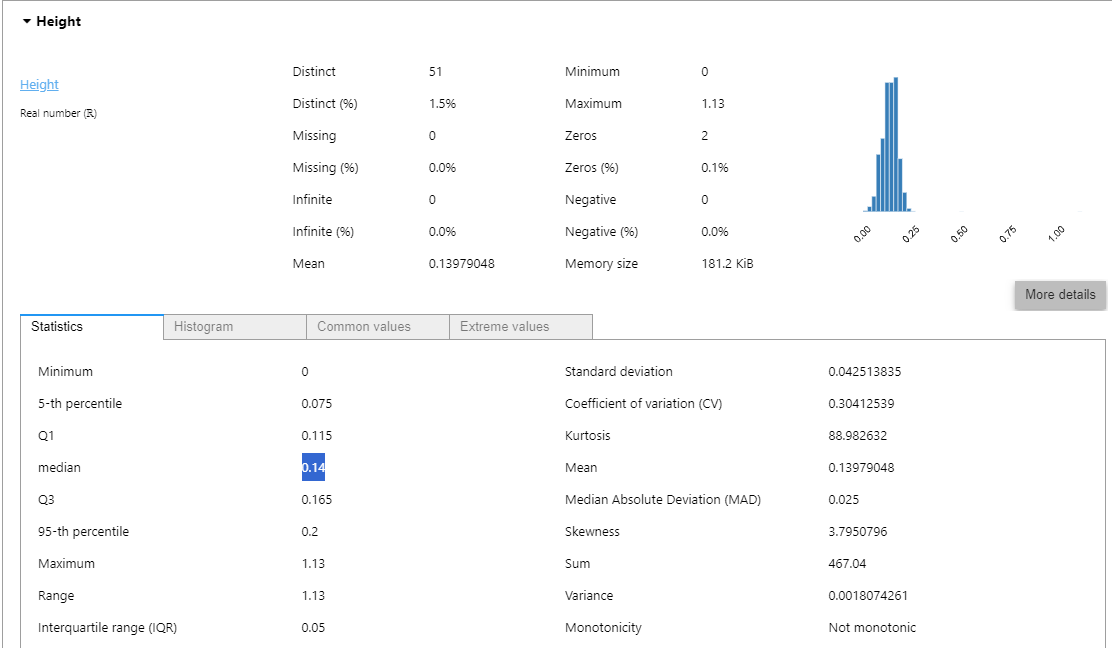
- Height i Rings posiada rozkłady normalne symetryczne a reszta normalne skośne.
- Z racji, że zbiór był pod zadanie regresji liczby pierścieni, to można zauważyć pozytywną korelację liniową innych cech z Rings.

## Basic Analysis

In [8]:
df_to_profile.head()

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
4038   I   0.550     0.445   0.125        0.6720          0.2880   
1272   I   0.475     0.355   0.100        0.5035          0.2535   
3384   F   0.305     0.225   0.070        0.1485          0.0585   
3160   I   0.275     0.200   0.065        0.1165          0.0565   
3894   M   0.495     0.380   0.135        0.6295          0.2630   

      Viscera_weight  Shell_weight  Rings  
4038          0.1365         0.210     11  
1272          0.0910         0.140      8  
3384          0.0335         0.045      7  
3160          0.0130         0.035      7  
3894          0.1425         0.215     12

In [9]:
# descirbe the data
df_to_profile.describe()

Length     Diameter       Height  Whole_weight  Shucked_weight  \
count  3341.000000  3341.000000  3341.000000   3341.000000     3341.000000   
mean      0.524964     0.408518     0.139790      0.830838        0.360561   
std       0.119137     0.098687     0.042514      0.491583        0.223018   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.443000        0.186500   
50%       0.545000     0.425000     0.140000      0.802000        0.337000   
75%       0.615000     0.480000     0.165000      1.151000        0.503500   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera_weight  Shell_weight        Rings  
count     3341.000000   3341.000000  3341.000000  
mean         0.180832      0.239682     9.944627  
std          0.109444      0.139941     3.207344  
min          0.000500      0.001500     1.000000  
25%          0.093000      0.130000     8.000000  
50%          0.171000      0.234000     9.000000  
75%          0.253500      0.328500    11.000000  
max          0.760000      1.005000    29.000000

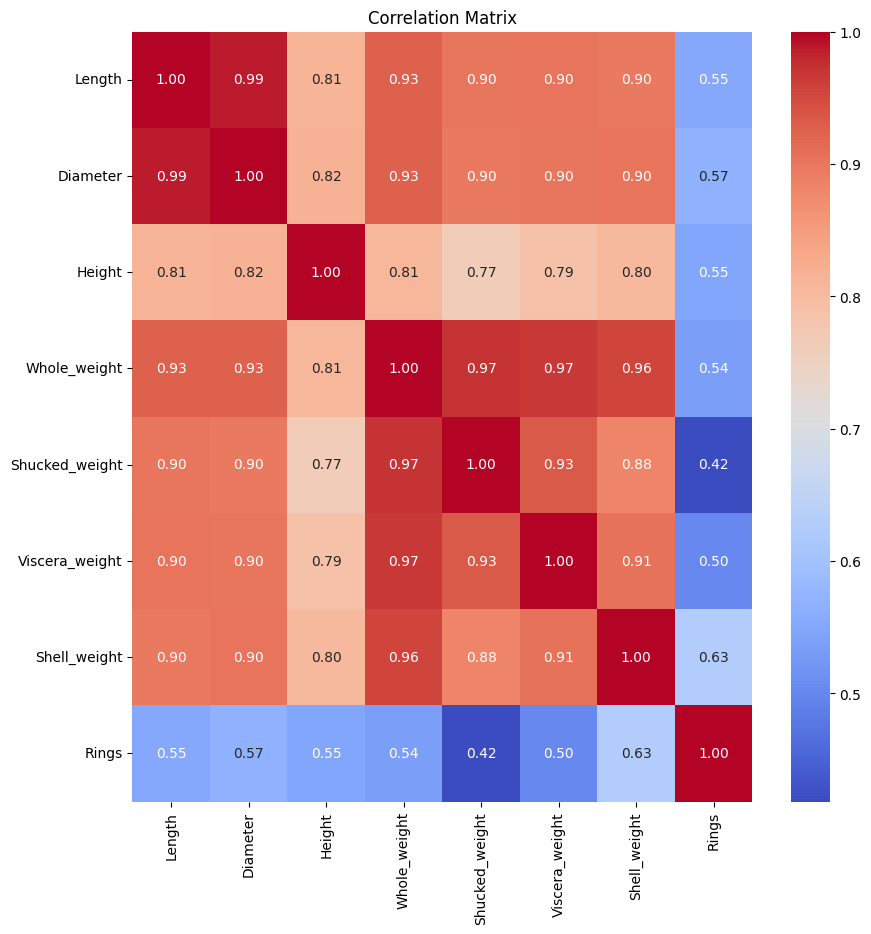

In [44]:
# list all numerical columns
%matplotlib inline
numerical_columns = df_to_profile.select_dtypes(include=[np.number]).columns.tolist()

corr = df_to_profile[numerical_columns].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


- Wiele cech jest mocno poztywnie skorelowanych ze sobą, oznacza to że są redundantne i można jes zastąpić jedną cechą.

## Preprocessing danych

### Normalizacja


In [11]:
from sklearn.preprocessing import MinMaxScaler

X_train_n = X_train.copy()
X_test_n = X_test.copy()

numeric_cols = X_train.select_dtypes(include=[np.number]).columns

scaler = MinMaxScaler()

df_normalized_train = scaler.fit_transform(X_train[numeric_cols])
X_train_n[numeric_cols] = df_normalized_train

df_normalized_test = scaler.transform(X_test[numeric_cols])
X_test_n[numeric_cols] = df_normalized_test

y_train_n = y_train.copy()
y_test_n = y_test.copy()

scaler_y = MinMaxScaler()

df_normalized_train_y = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_train_n = df_normalized_train_y

df_normalized_test_y = scaler_y.transform(y_test.values.reshape(-1, 1))
y_test_n = df_normalized_test_y

### Kodowanie zmiennych kategorycznych

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_train_n["Sex"] = le.fit_transform(X_train_n["Sex"])
X_test_n["Sex"] = le.transform(X_test_n["Sex"])

In [13]:
X_train_n.head()

Sex    Length  Diameter    Height  Whole_weight  Shucked_weight  \
4038    1  0.641892  0.655462  0.110619      0.237294        0.193006   
1272    1  0.540541  0.504202  0.088496      0.177616        0.169805   
3384    0  0.310811  0.285714  0.061947      0.051886        0.038668   
3160    1  0.270270  0.243697  0.057522      0.040553        0.037323   
3894    2  0.567568  0.546218  0.119469      0.222242        0.176194   

      Viscera_weight  Shell_weight  
4038        0.179065      0.207773  
1272        0.119157      0.138017  
3384        0.043450      0.043348  
3160        0.016458      0.033383  
3894        0.186965      0.212755

In [14]:
X_test_n.head()

Sex    Length  Diameter    Height  Whole_weight  Shucked_weight  \
866     2  0.716216  0.672269  0.141593      0.390119        0.282448   
1483    2  0.695946  0.647059  0.132743      0.308305        0.259583   
599     0  0.655405  0.655462  0.172566      0.346733        0.204438   
1702    0  0.756757  0.731092  0.150442      0.446078        0.361466   
670     2  0.540541  0.554622  0.128319      0.217992        0.157364   

      Viscera_weight  Shell_weight  
866         0.396313      0.322372  
1483        0.282423      0.242651  
599         0.294931      0.332337  
1702        0.350230      0.377180  
670         0.141540      0.212755

# PCA a wymiary

In [15]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
def plot_variance_explained(df):
    pca = PCA()
    pca.fit(df)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
    axs[0].set_xlabel('Principal Components')
    axs[0].set_ylabel('Explained Variance')
    axs[0].set_title('Explained Variance')
    axs[0].grid(True)

    axs[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axs[1].set_xlabel('Principal Components')
    axs[1].set_ylabel('Cumulative Variance Explained')
    axs[1].set_title('Cumulative Variance Explained')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

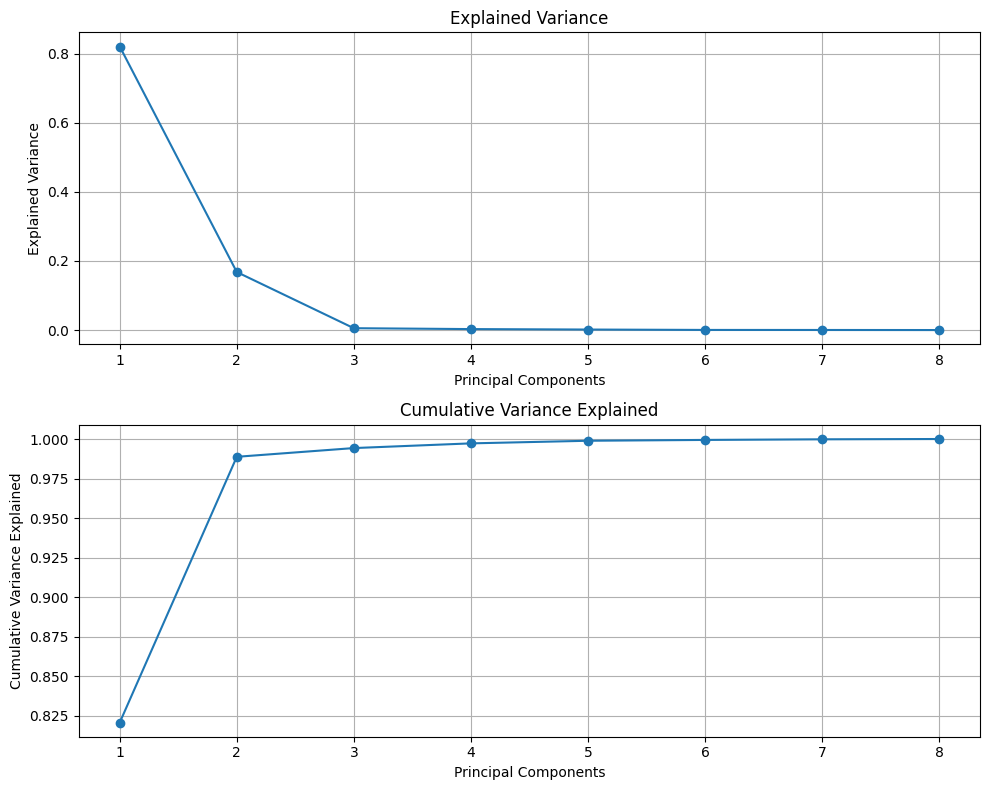

In [16]:
plot_variance_explained(X_train_n)

# KMeans
### Działanie algorytmu
1. Wybierz liczbę klastrów K
1. Inicjalizuj K punktów jako centroidy
    1. może być losowo
    1. lub aplikując k-means++ (lepsze wyniki)
1. Dla każdego punktu przypisz go do najbliższego centroidu
1. Zaktualizuj centroidy jako średnią wszystkich punktów przypisanych do danego klastra
1. Powtarzaj kroki 3 i 4 aż do zbieżności


## Jak dobrać ilość klastrów w KMeans ?

- Metoda łokcia (Elbow Method) - polega na wyznaczeniu optymalnej ilości klastrów na podstawie wykresu zależności Inertia (Suma kwadratów odległości próbek od ich najbliższego centroidu) od ilości klastrów. Optymalna ilość klastrów to punkt przegięcia wykresu.

In [17]:
def plot_elbow(df):
    inertia = []

    k_values = range(1, 20)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)

    plt.plot(k_values, inertia, marker='o')
    plt.xticks(k_values)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot')
    plt.grid(True)
    plt.show()

c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


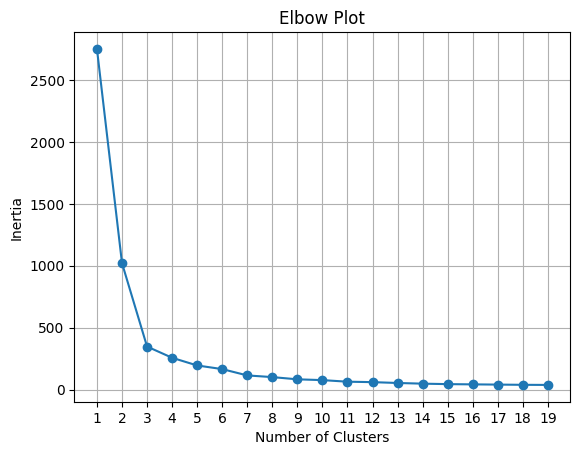

In [18]:
plot_elbow(X_train_n)

- Można też użyć innych metryk jak Silhouette Score, Calinski-Harabasz Score, Davies-Bouldin Score.

## Sihouette Score 
- Silhouette Score jest metryką używaną do oceny jakości podziału punktów danych na klastry.
- Wartość Silhouette Score mieści się w przedziale od -1 do 1, gdzie:
    - bliskie 1 oznacza, że obserwacje są dobrze przypisane do klastrów i źle przypisane do innych klastrów
    - bliskie 0 oznacza, że obserwacje są równo przypisane do klastrów
    - bliskie -1 oznacza, że obserwacje są źle przypisane do klastrów

- miara słada się z:
    - a - średnia odległość między punktem a innymi punktami w klastrze
    - b -  średnia odległość między punktem a punktami z innego najbliższego klastra
Wzór na Silhouette Score:
$$s = \frac{b - a}{max(a, b)}$$

## Calinski-Harabasz Score 
- Calinski-Harabasz Score jest metryką wewnętrzną, która mierzy kompakcyjność klastrów i odległości między nimi.
- Im wyższa wartość Calinski-Harabasz Score, tym lepszy podział punktów na klastry.
- Metryka ta oblicza stosunek wariancji między klastrami do wariancji wewnątrz klastrów.
## Davies-Bouldin Score 
- Davies-Bouldin Score jest również metryką wewnętrzną, która mierzy jakość podziału klastrów.
- Im niższa wartość Davies-Bouldin Score, tym lepsza sepraca między klastrami i bardziej jednorodne klastry.
- DB Score oblicza średnią wartość odległości między każdym klastrami, podzieloną przez odległość między centroidami klastrów.
- Obliczeniowo DB jest łatwiejszy niż Sihouette Score.


In [19]:
def plot_metrics_kmeans(df: pd.DataFrame):

    silhouette_scores_KMEANS = []
    calinski_harabasz_scores_KMEANS = []
    davies_bouldin_scores_KMEANS = []

    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, random_state=random)
        kmeans.fit(df)
        y_kmeans = kmeans.predict(df)
        silhouette_scores_KMEANS.append(silhouette_score(df, y_kmeans))
        calinski_harabasz_scores_KMEANS.append(calinski_harabasz_score(df, y_kmeans))
        davies_bouldin_scores_KMEANS.append(davies_bouldin_score(df, y_kmeans))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].plot(range(2, 11), silhouette_scores_KMEANS, marker="o", color="b")
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Number of clusters")

    best_k = silhouette_scores_KMEANS.index(max(silhouette_scores_KMEANS)) + 2
    axs[0].axvline(x=best_k, color="r", linestyle="-.")
    axs[0].axhline(y=max(silhouette_scores_KMEANS), color="g", linestyle="--")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)


    axs[1].plot(range(2, 11), calinski_harabasz_scores_KMEANS, marker="o", color="r")
    best_k = (
        calinski_harabasz_scores_KMEANS.index(max(calinski_harabasz_scores_KMEANS)) + 2
    )
    axs[1].axvline(x=best_k, color="r", linestyle="-.")
    axs[1].axhline(y=max(calinski_harabasz_scores_KMEANS), color="g", linestyle="--")
    axs[1].set_title("Calinski Harabasz Score")
    axs[1].set_xlabel("Number of clusters")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    best_k = davies_bouldin_scores_KMEANS.index(min(davies_bouldin_scores_KMEANS)) + 2
    axs[2].plot(range(2, 11), davies_bouldin_scores_KMEANS, marker="o", color="g")
    axs[2].axvline(x=best_k, color="r", linestyle="-.")
    axs[2].axhline(y=min(davies_bouldin_scores_KMEANS), color="g", linestyle="--")
    axs[2].set_title("Davies Bouldin Score")
    axs[2].set_xlabel("Number of clusters")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)


    plt.tight_layout()

    plt.show()

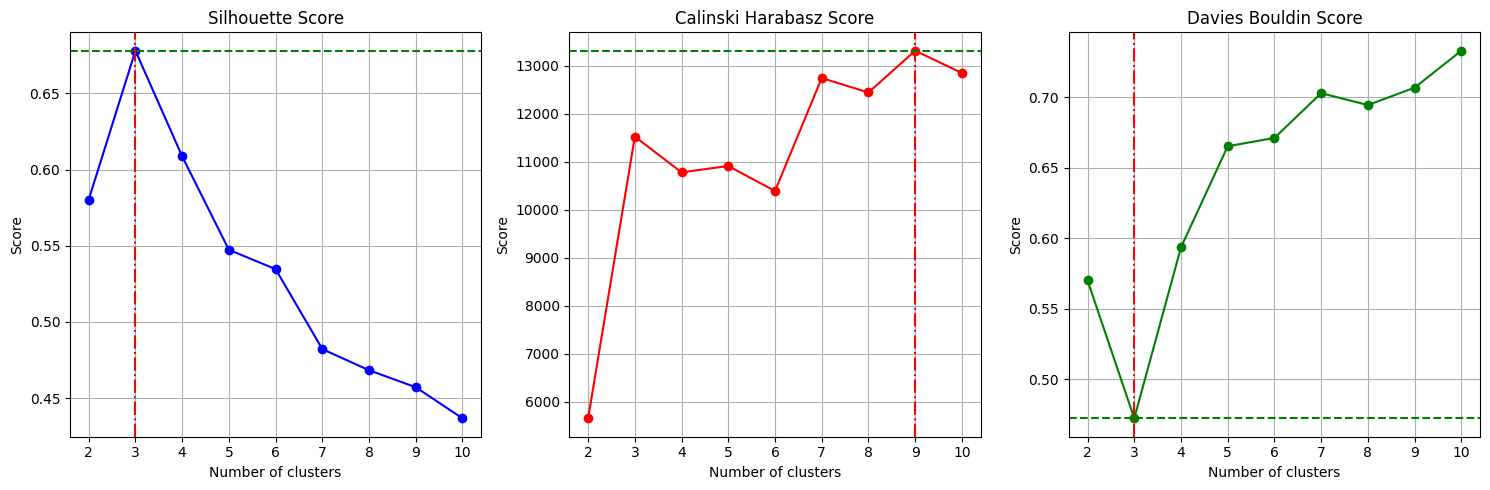

In [20]:
plot_metrics_kmeans(X_train_n)

## Wizualizacja grupowania poprzez dwie cechy a redukcję cech

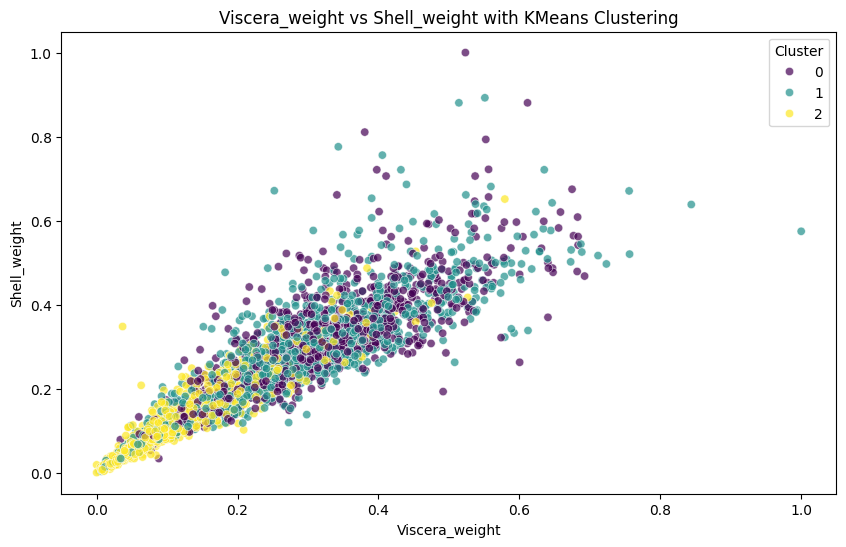

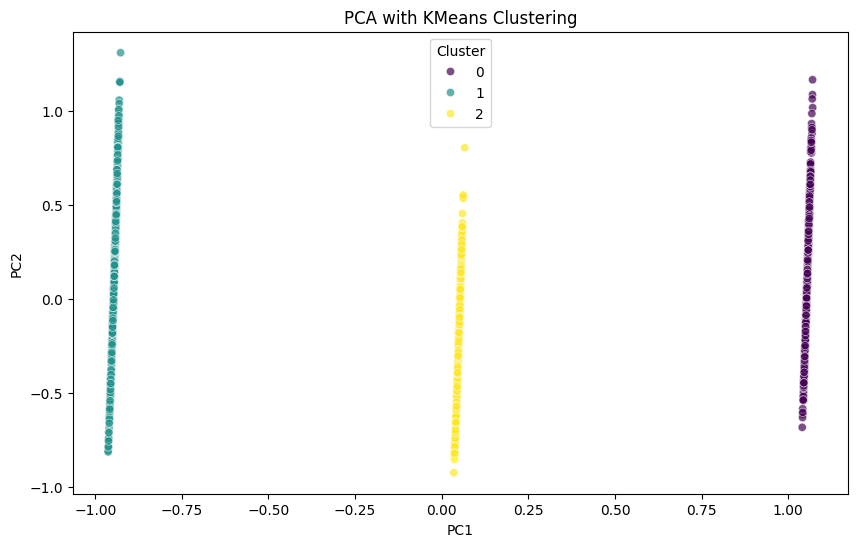

In [21]:
kmeans = KMeans(n_clusters=3, random_state=random)
kmeans.fit(X_train_n)
y_kmeans = kmeans.predict(X_train_n)

df_clustered = X_train_n.copy()
df_clustered['Cluster'] = y_kmeans


feat1 = "Viscera_weight"
feat2 = "Shell_weight"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clustered, x=feat1, y=feat2, hue='Cluster', palette='viridis', alpha=0.7)
plt.title(f'{feat1} vs {feat2} with KMeans Clustering')
plt.show()

# Plot clusters using PCA
pca = PCA(n_components=2)
pca.fit(X_train_n)
df_pca = pca.transform(X_train_n)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = y_kmeans

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=df_pca['Cluster'], palette='viridis', alpha=0.7)
plt.title('PCA with KMeans Clustering')
plt.show()

## Wszytskie pary cech

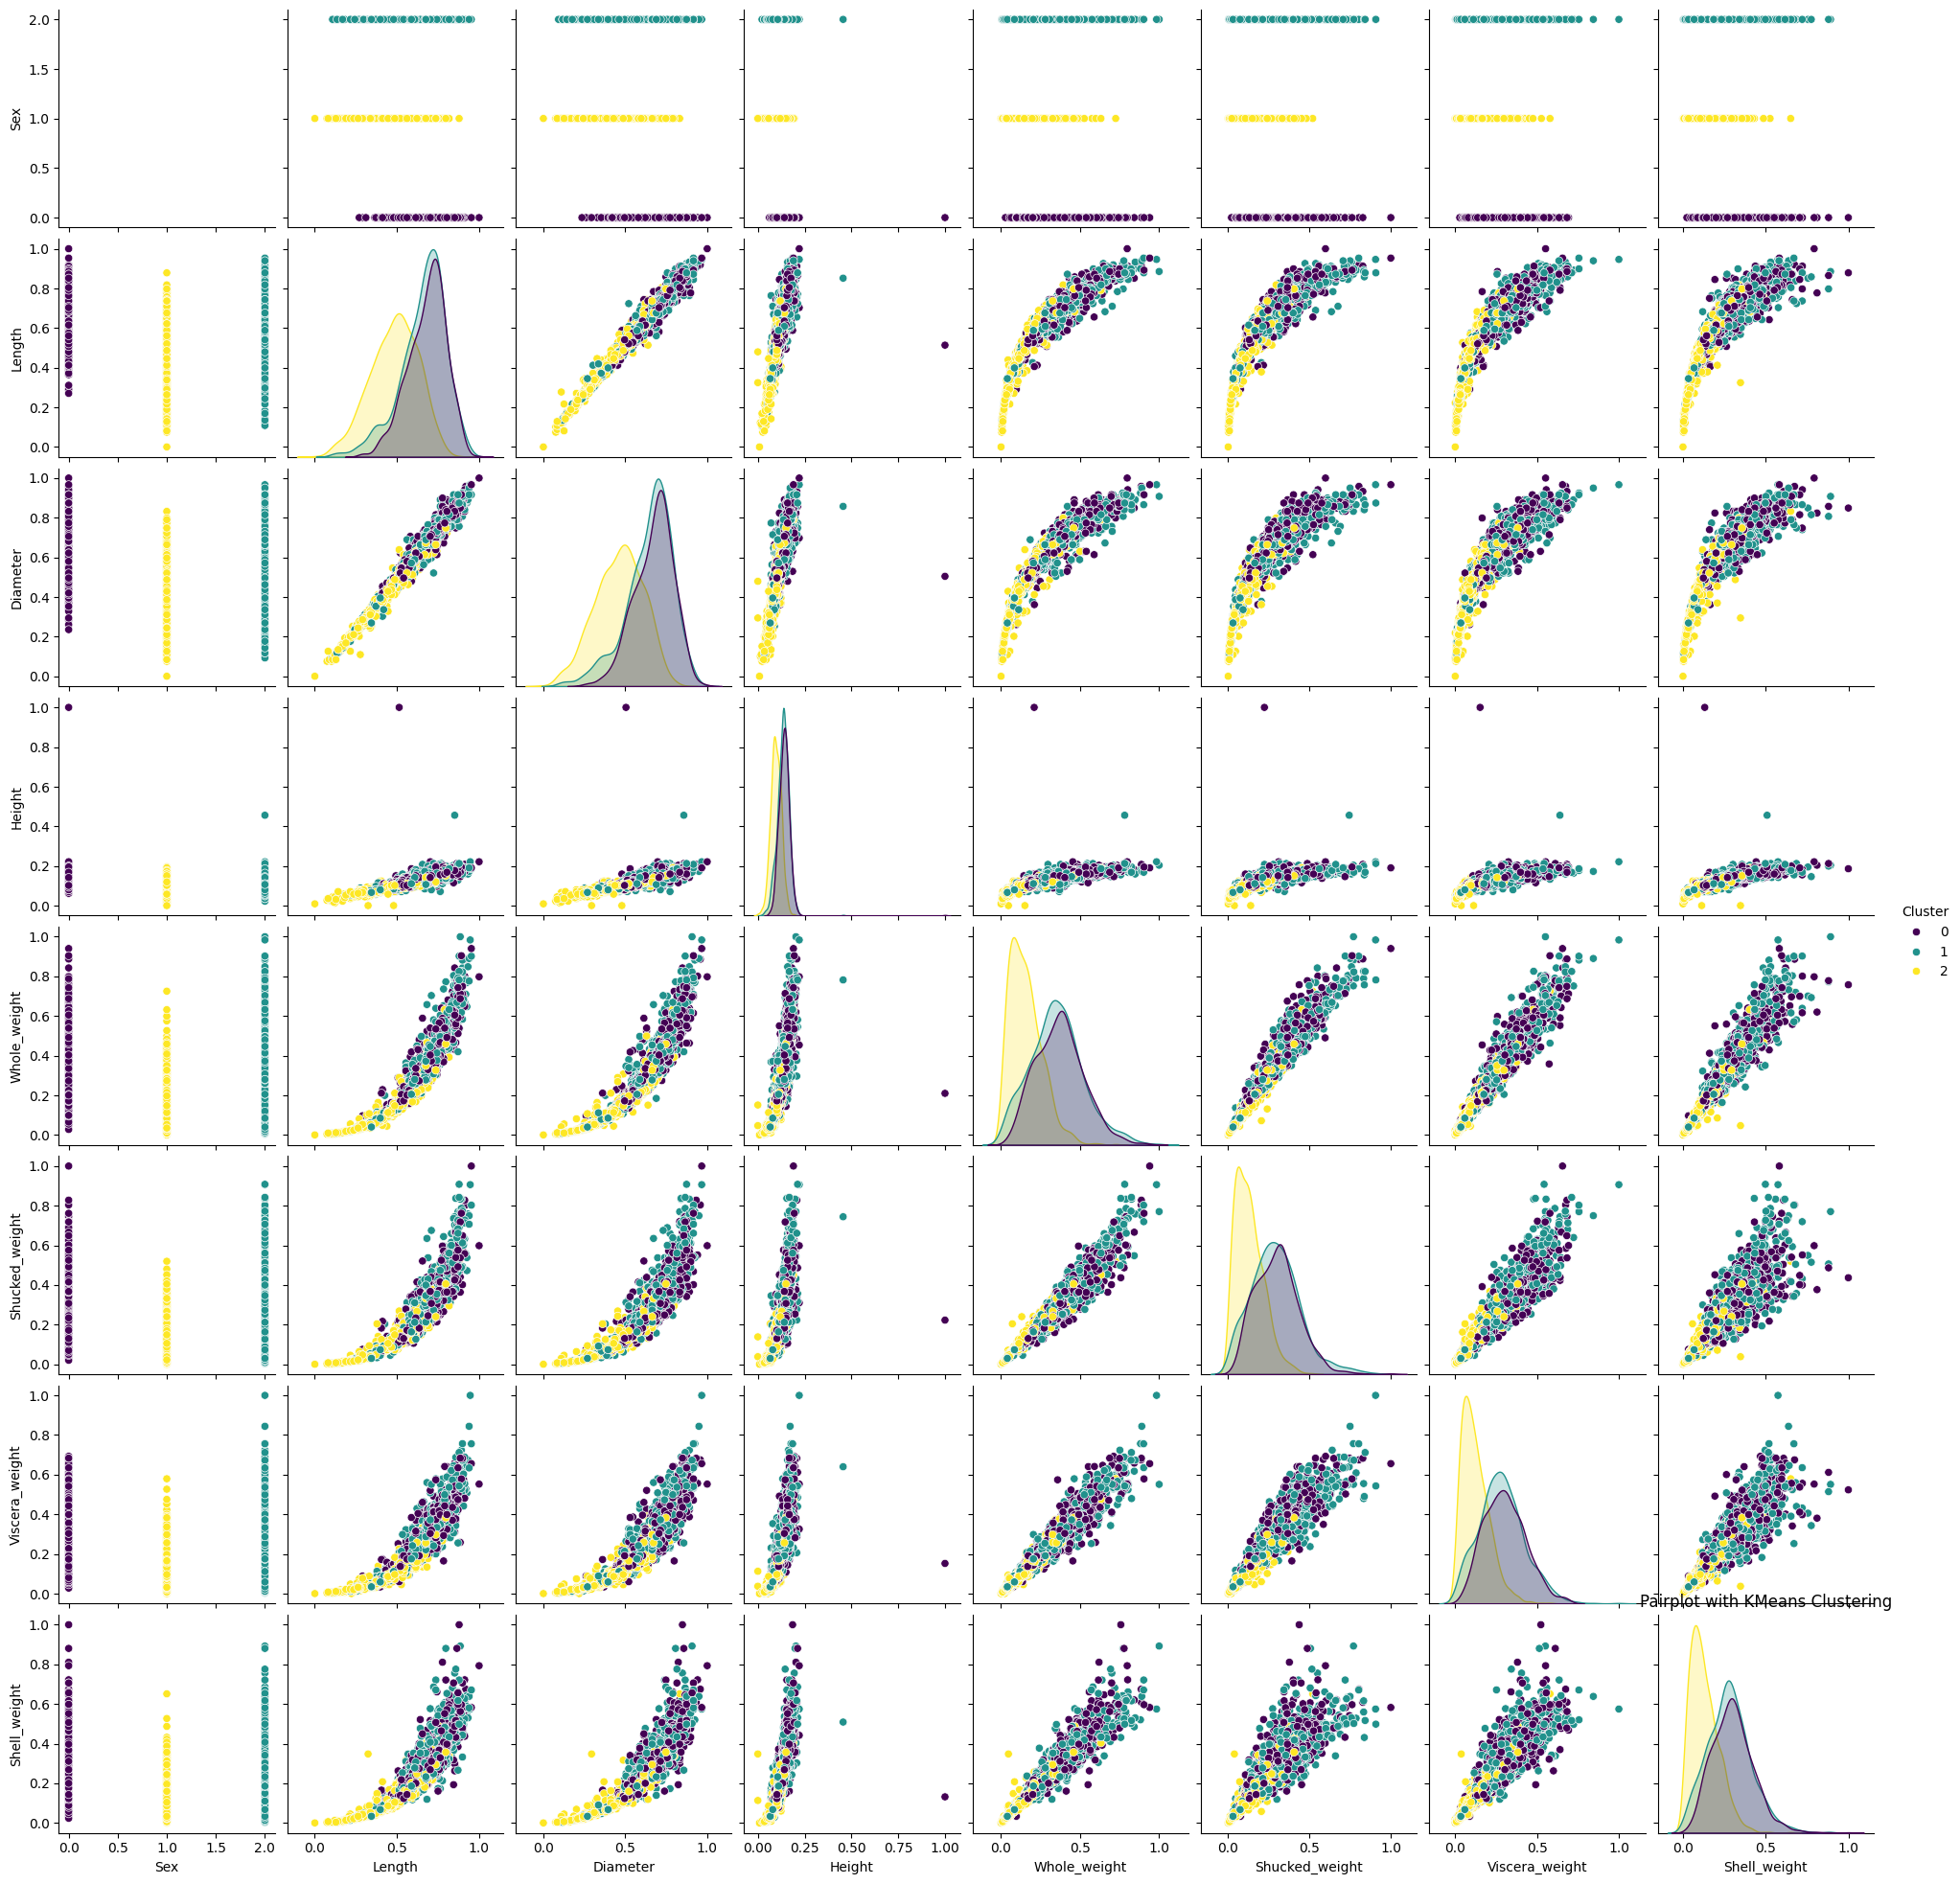

In [22]:
sns.pairplot(df_clustered, hue='Cluster', palette='viridis')
plt.title('Pairplot with KMeans Clustering')
plt.show()


# Grupowanie po redukcji cech


In [23]:
# use pca to do dimension reduction
pca = PCA(n_components=3, random_state=random)
principalComponents = pca.fit_transform(X_train_n)
display(X_train_n.head())
# Create a DataFrame with the principal components
principalDf3 = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
# KMeans clustering
kmeans_pca = KMeans(n_clusters=3, random_state=random)
kmeans_pca.fit(principalDf3)
y_kmeans_pca = kmeans_pca.predict(principalDf3)

# Create a DataFrame with the cluster labels
df_clustered_pca = principalDf3.copy()
df_clustered_pca['Cluster'] = y_kmeans_pca

# Plot clusters using PCA also add centroids
fig = px.scatter_3d(df_clustered_pca, x='PC1', y='PC2', z='PC3', color='Cluster', opacity=0.5, width=800, height=800)

fig.show()

Sex    Length  Diameter    Height  Whole_weight  Shucked_weight  \
4038    1  0.641892  0.655462  0.110619      0.237294        0.193006   
1272    1  0.540541  0.504202  0.088496      0.177616        0.169805   
3384    0  0.310811  0.285714  0.061947      0.051886        0.038668   
3160    1  0.270270  0.243697  0.057522      0.040553        0.037323   
3894    2  0.567568  0.546218  0.119469      0.222242        0.176194   

      Viscera_weight  Shell_weight  
4038        0.179065      0.207773  
1272        0.119157      0.138017  
3384        0.043450      0.043348  
3160        0.016458      0.033383  
3894        0.186965      0.212755

## Wpływ cechy tergetowej na klastrowanie
- Sprawdzenie czy cecha targetowa ma wpływ na klastrowanie
- okazuje się, że różnica cech kategorycznych jest na tyle zauważalna, że nie ma to wpływu na klastrowanie


In [24]:
XY_train_n = X_train_n.copy()
XY_train_n['Rings'] = y_train_n

XY_test_n = X_test_n.copy()
XY_test_n['Rings'] = y_test_n



In [25]:

pca = PCA(n_components=3, random_state=random)
principalComponents = pca.fit_transform(XY_train_n)

display(XY_train_n.head())

principalDf3 = pd.DataFrame(data=principalComponents, columns=["PC1", "PC2", "PC3"])
# KMeans clustering
kmeans_pca = KMeans(n_clusters=3, random_state=random)
kmeans_pca.fit(principalDf3)
y_kmeans_pca = kmeans_pca.predict(principalDf3)

df_clustered_pca = principalDf3.copy()
df_clustered_pca["Cluster"] = y_kmeans_pca

fig = px.scatter_3d(
    df_clustered_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Cluster",
    opacity=0.5,
    width=800,
    height=800,
)

fig.show()

Sex    Length  Diameter    Height  Whole_weight  Shucked_weight  \
4038    1  0.641892  0.655462  0.110619      0.237294        0.193006   
1272    1  0.540541  0.504202  0.088496      0.177616        0.169805   
3384    0  0.310811  0.285714  0.061947      0.051886        0.038668   
3160    1  0.270270  0.243697  0.057522      0.040553        0.037323   
3894    2  0.567568  0.546218  0.119469      0.222242        0.176194   

      Viscera_weight  Shell_weight     Rings  
4038        0.179065      0.207773  0.357143  
1272        0.119157      0.138017  0.250000  
3384        0.043450      0.043348  0.214286  
3160        0.016458      0.033383  0.214286  
3894        0.186965      0.212755  0.392857

## Analiza hiperparametrów metod wraz z odpowiednimi wizualizacjami danych.

### Liczba klastrów

MovieWriter imagemagick unavailable; using Pillow instead.


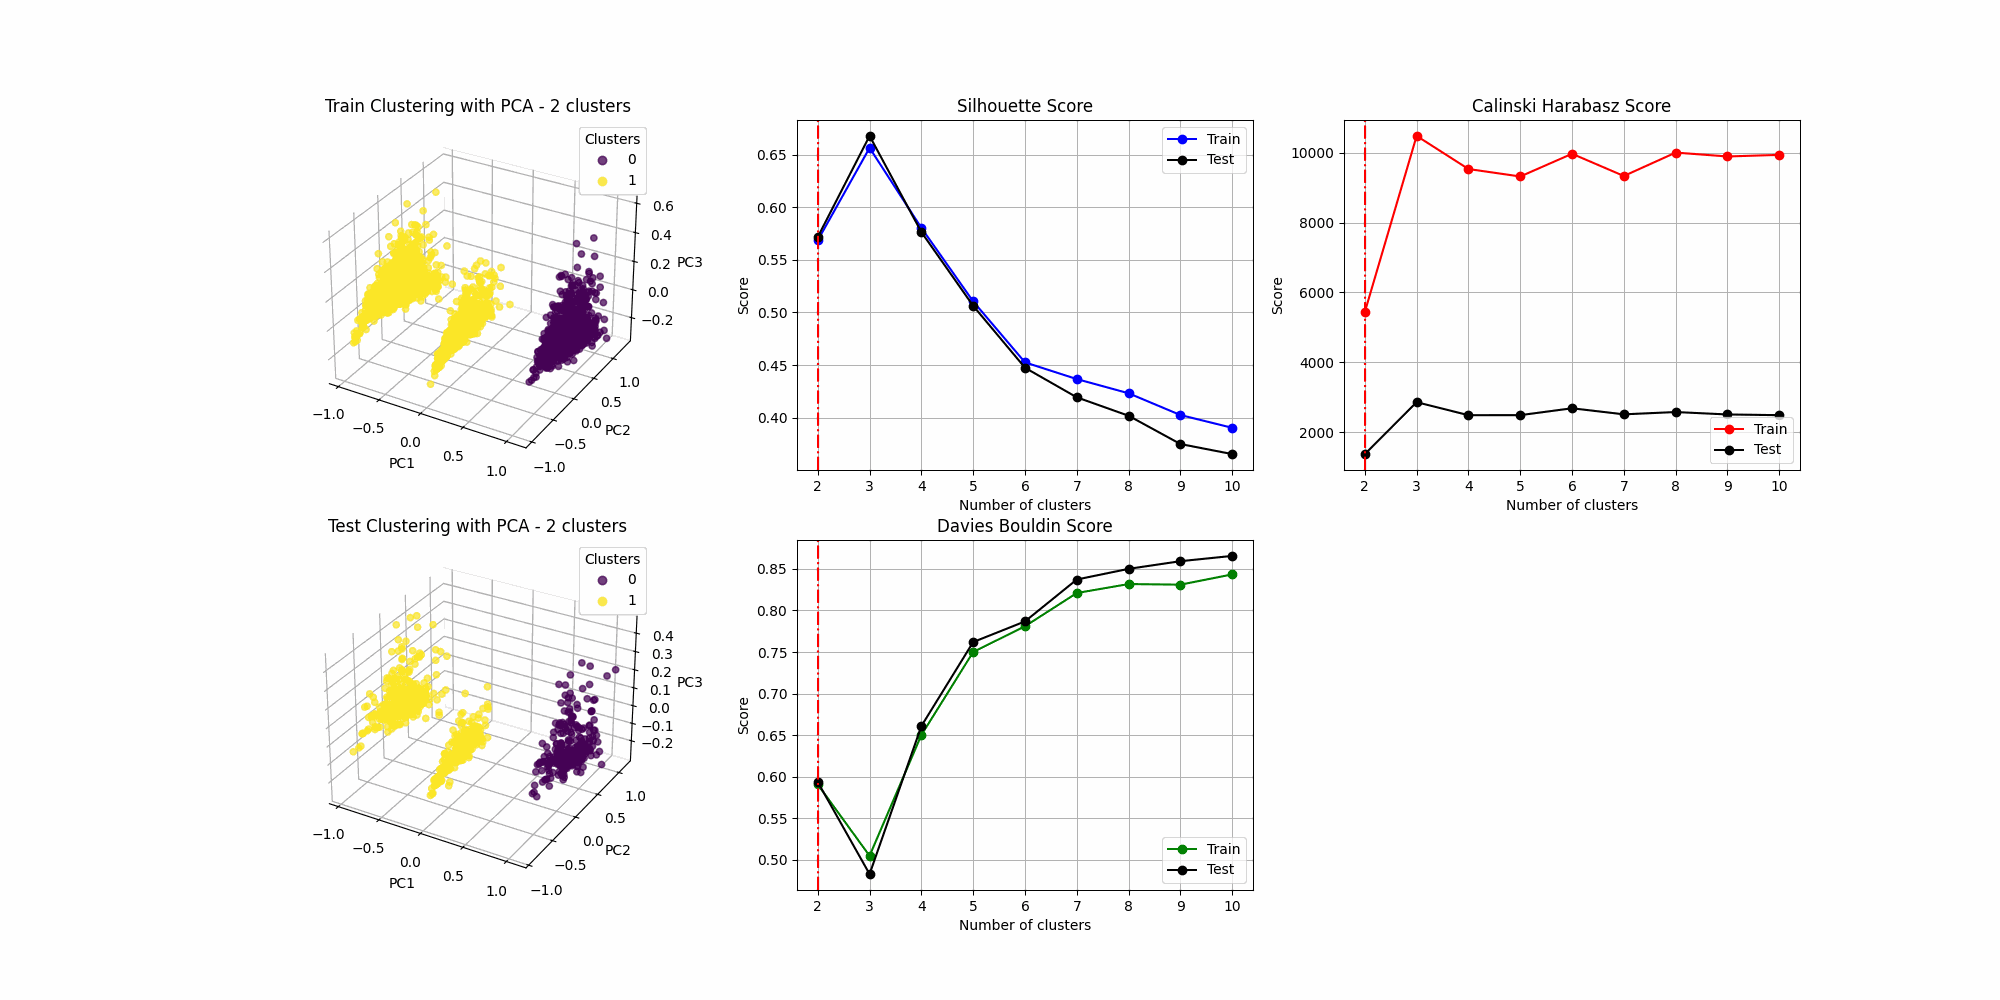

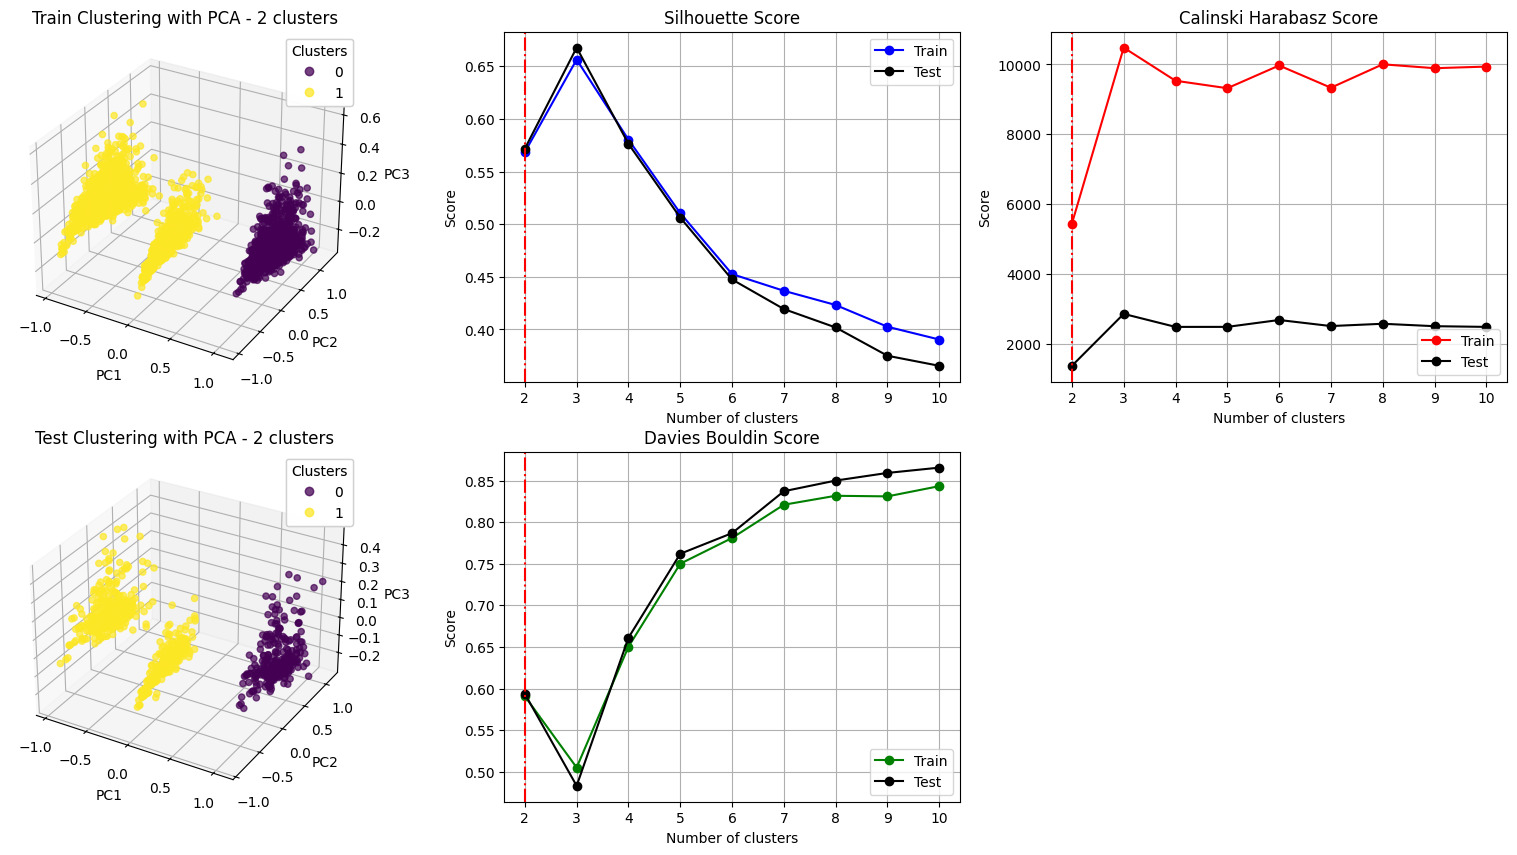

In [26]:
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
def animate_hiperparameters(dataframe, test):
    # Perform PCA to reduce to 3 dimensions for visualization
    pca = PCA(n_components=3)
    principalDf3 = pd.DataFrame(
        pca.fit_transform(dataframe), columns=["PC1", "PC2", "PC3"]
    )

    pca_test = pd.DataFrame(
        pca.transform(test), columns=["PC1", "PC2", "PC3"]
    )

    # Initialize lists to store metrics
    silhouette_scores_KMEANS = []
    calinski_harabasz_scores_KMEANS = []
    davies_bouldin_scores_KMEANS = []

    silhouette_scores_KMEANS_test = []
    calinski_harabasz_scores_KMEANS_test = []
    davies_bouldin_scores_KMEANS_test = []

    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(dataframe)
        y_kmeans = kmeans.predict(dataframe)
        y_test_kmeans = kmeans.predict(test)
        silhouette_scores_KMEANS.append(silhouette_score(dataframe, y_kmeans))
        calinski_harabasz_scores_KMEANS.append(calinski_harabasz_score(dataframe, y_kmeans))
        davies_bouldin_scores_KMEANS.append(davies_bouldin_score(dataframe, y_kmeans))

        silhouette_scores_KMEANS_test.append(silhouette_score(test, y_test_kmeans))
        calinski_harabasz_scores_KMEANS_test.append(calinski_harabasz_score(test, y_test_kmeans))
        davies_bouldin_scores_KMEANS_test.append(davies_bouldin_score(test, y_test_kmeans))

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(231, projection="3d")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")
    ax1.set_title("Train Clustering with PCA")

    ax2 = fig.add_subplot(234, projection="3d")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")
    ax2.set_title("Test Clustering with PCA")

    ax3 = fig.add_subplot(232)
    ax4 = fig.add_subplot(233)
    ax5 = fig.add_subplot(235)

    def update(num):
        ax1.cla()
        ax1.set_xlabel("PC1")
        ax1.set_ylabel("PC2")
        ax1.set_zlabel("PC3")
        ax1.set_title(f"Train Clustering with PCA - {num} clusters")

        ax2.cla()
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")
        ax2.set_zlabel("PC3")
        ax2.set_title(f"Test Clustering with PCA - {num} clusters")

        kmeans_pca = KMeans(n_clusters=num, random_state=42)
        kmeans_pca.fit(principalDf3)
        y_kmeans_pca = kmeans_pca.predict(principalDf3)
        y_kmeans_pca_test = kmeans_pca.predict(pca_test)

        df_clustered_pca = principalDf3.copy()
        df_clustered_pca["Cluster"] = y_kmeans_pca

        df_clustered_pca_test = pca_test.copy()
        df_clustered_pca_test["Cluster"] = y_kmeans_pca_test

        scatter1 = ax1.scatter(
            df_clustered_pca["PC1"],
            df_clustered_pca["PC2"],
            df_clustered_pca["PC3"],
            c=df_clustered_pca["Cluster"],
            cmap="viridis",
            alpha=0.7,
        )
        legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
        ax1.add_artist(legend1)

        scatter2 = ax2.scatter(
            df_clustered_pca_test["PC1"],
            df_clustered_pca_test["PC2"],
            df_clustered_pca_test["PC3"],
            c=df_clustered_pca_test["Cluster"],
            cmap="viridis",
            alpha=0.7,
        )
        legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
        ax2.add_artist(legend2)

        ax3.cla()
        ax4.cla()
        ax5.cla()

        ax3.plot(range(2, 11), silhouette_scores_KMEANS, marker="o", color="b", label="Train")
        ax3.plot(range(2, 11), silhouette_scores_KMEANS_test, marker="o", color="k", label="Test")
        ax3.set_title("Silhouette Score")
        ax3.set_xlabel("Number of clusters")
        ax3.set_ylabel("Score")
        ax3.grid(True)
        ax3.axvline(x=num, color="r", linestyle="-.")
        ax3.legend()

        ax4.plot(range(2, 11), calinski_harabasz_scores_KMEANS, marker="o", color="r", label="Train")
        ax4.plot(range(2, 11), calinski_harabasz_scores_KMEANS_test, marker="o", color="k", label="Test")
        ax4.set_title("Calinski Harabasz Score")
        ax4.set_xlabel("Number of clusters")
        ax4.set_ylabel("Score")
        ax4.grid(True)
        ax4.axvline(x=num, color="r", linestyle="-.")
        ax4.legend()

        ax5.plot(range(2, 11), davies_bouldin_scores_KMEANS, marker="o", color="g", label="Train")
        ax5.plot(range(2, 11), davies_bouldin_scores_KMEANS_test, marker="o", color="k", label="Test")
        ax5.set_title("Davies Bouldin Score")
        ax5.set_xlabel("Number of clusters")
        ax5.set_ylabel("Score")
        ax5.grid(True)
        ax5.axvline(x=num, color="r", linestyle="-.")
        ax5.legend()

    ani = animation.FuncAnimation(fig, update, frames=range(2,11), repeat=True)
    ani.save("kmeans_pca.gif", writer="imagemagick", fps=1)


anim = animate_hiperparameters(XY_train_n, XY_test_n)
from IPython.display import Image
Image(filename="kmeans_pca.gif")

### Init - metoda inicjalizacji centroidów

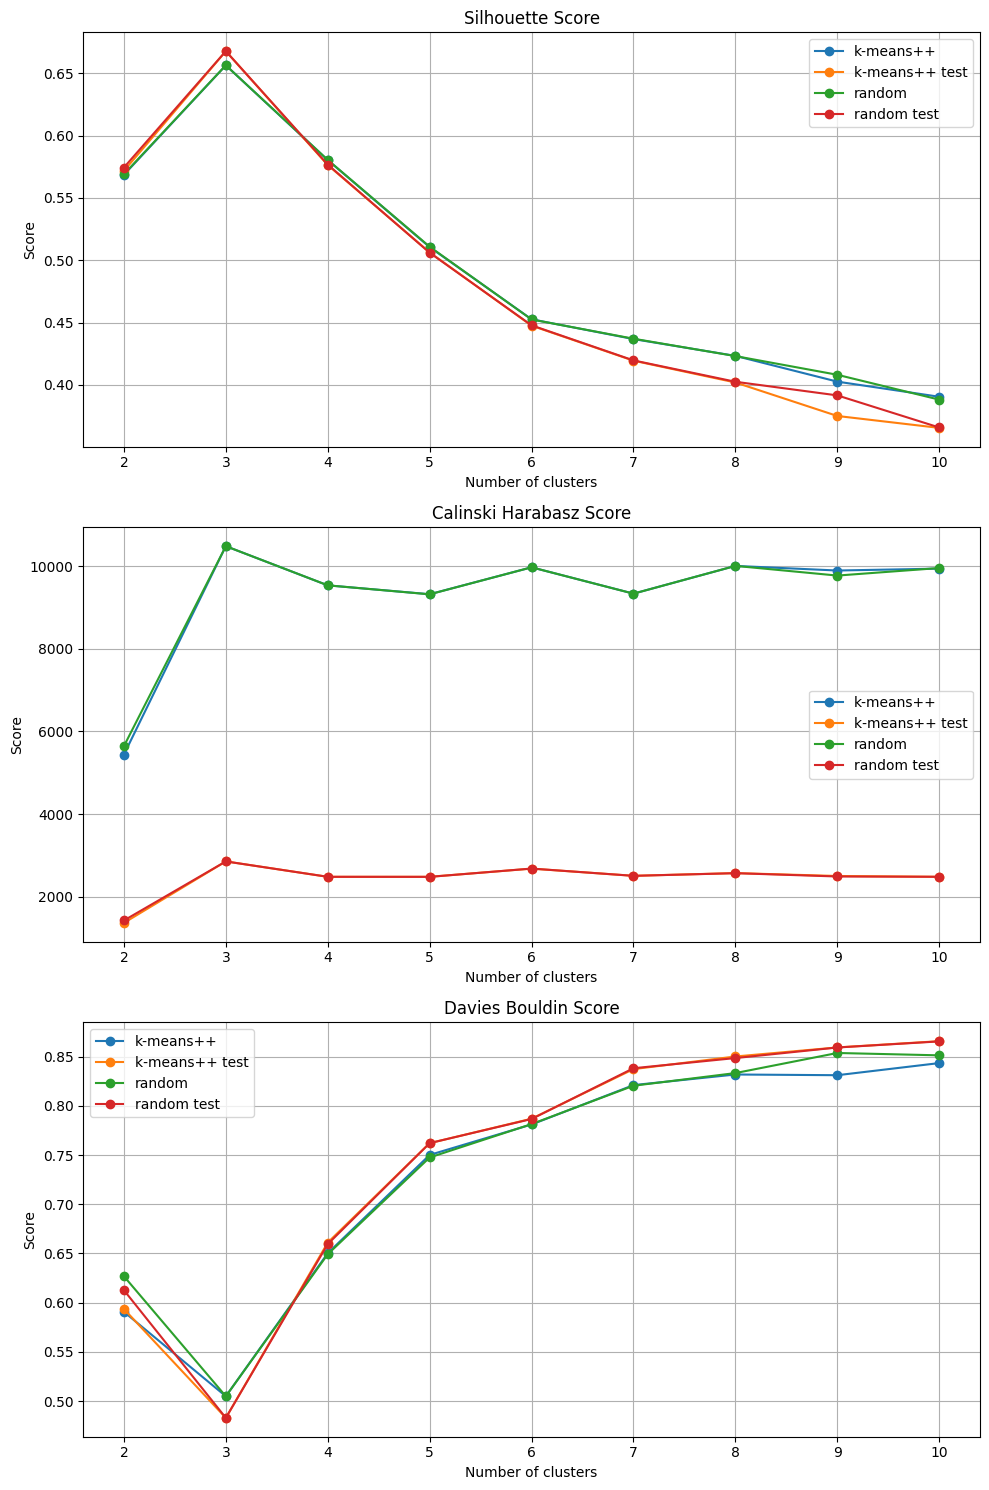

In [27]:
def test_kmeans_init_hyperparameter(dataframe, test):
    # Different init methods to test
    # use pca to
    init_methods = ["k-means++", "random"]

    # Initialize lists to store metrics for different init methods
    silhouette_scores = {method: [] for method in init_methods}
    calinski_harabasz_scores = {method: [] for method in init_methods}
    davies_bouldin_scores = {method: [] for method in init_methods}

    silhouette_scores_test = {method: [] for method in init_methods}
    calinski_harabasz_scores_test = {method: [] for method in init_methods}
    davies_bouldin_scores_test = {method: [] for method in init_methods}


    # Calculate metrics for different init methods and number of clusters
    for method in init_methods:
        for n_clusters in range(2, 11):
            kmeans = KMeans(n_clusters=n_clusters, init=method, random_state=42)
            kmeans.fit(dataframe)
            y_kmeans = kmeans.predict(dataframe)
            y_test_kmeans = kmeans.predict(test)

            silhouette_scores[method].append(silhouette_score(dataframe, y_kmeans))
            calinski_harabasz_scores[method].append(
                calinski_harabasz_score(dataframe, y_kmeans)
            )
            davies_bouldin_scores[method].append(
                davies_bouldin_score(dataframe, y_kmeans)
            )

            silhouette_scores_test[method].append(silhouette_score(test, y_test_kmeans))
            calinski_harabasz_scores_test[method].append(
                calinski_harabasz_score(test, y_test_kmeans)
            )
            davies_bouldin_scores_test[method].append(
                davies_bouldin_score(test, y_test_kmeans)
            )
            


    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    for method in init_methods:
        axs[0].plot(range(2, 11), silhouette_scores[method], marker="o", label=method)
        axs[0].plot(range(2, 11), silhouette_scores_test[method], marker="o", label=method+" test")
        axs[1].plot(
            range(2, 11), calinski_harabasz_scores[method], marker="o", label=method
        )
        axs[1].plot(
            range(2, 11), calinski_harabasz_scores_test[method], marker="o", label=method+" test"
        )
        axs[2].plot(
            range(2, 11), davies_bouldin_scores[method], marker="o", label=method
        )
        axs[2].plot(
            range(2, 11), davies_bouldin_scores_test[method], marker="o", label=method+" test"
        )

    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Number of clusters")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title("Calinski Harabasz Score")
    axs[1].set_xlabel("Number of clusters")
    axs[1].set_ylabel("Score")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].set_title("Davies Bouldin Score")
    axs[2].set_xlabel("Number of clusters")
    axs[2].set_ylabel("Score")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


test_kmeans_init_hyperparameter(XY_train_n, XY_test_n)

### Badanie parametru iteracji

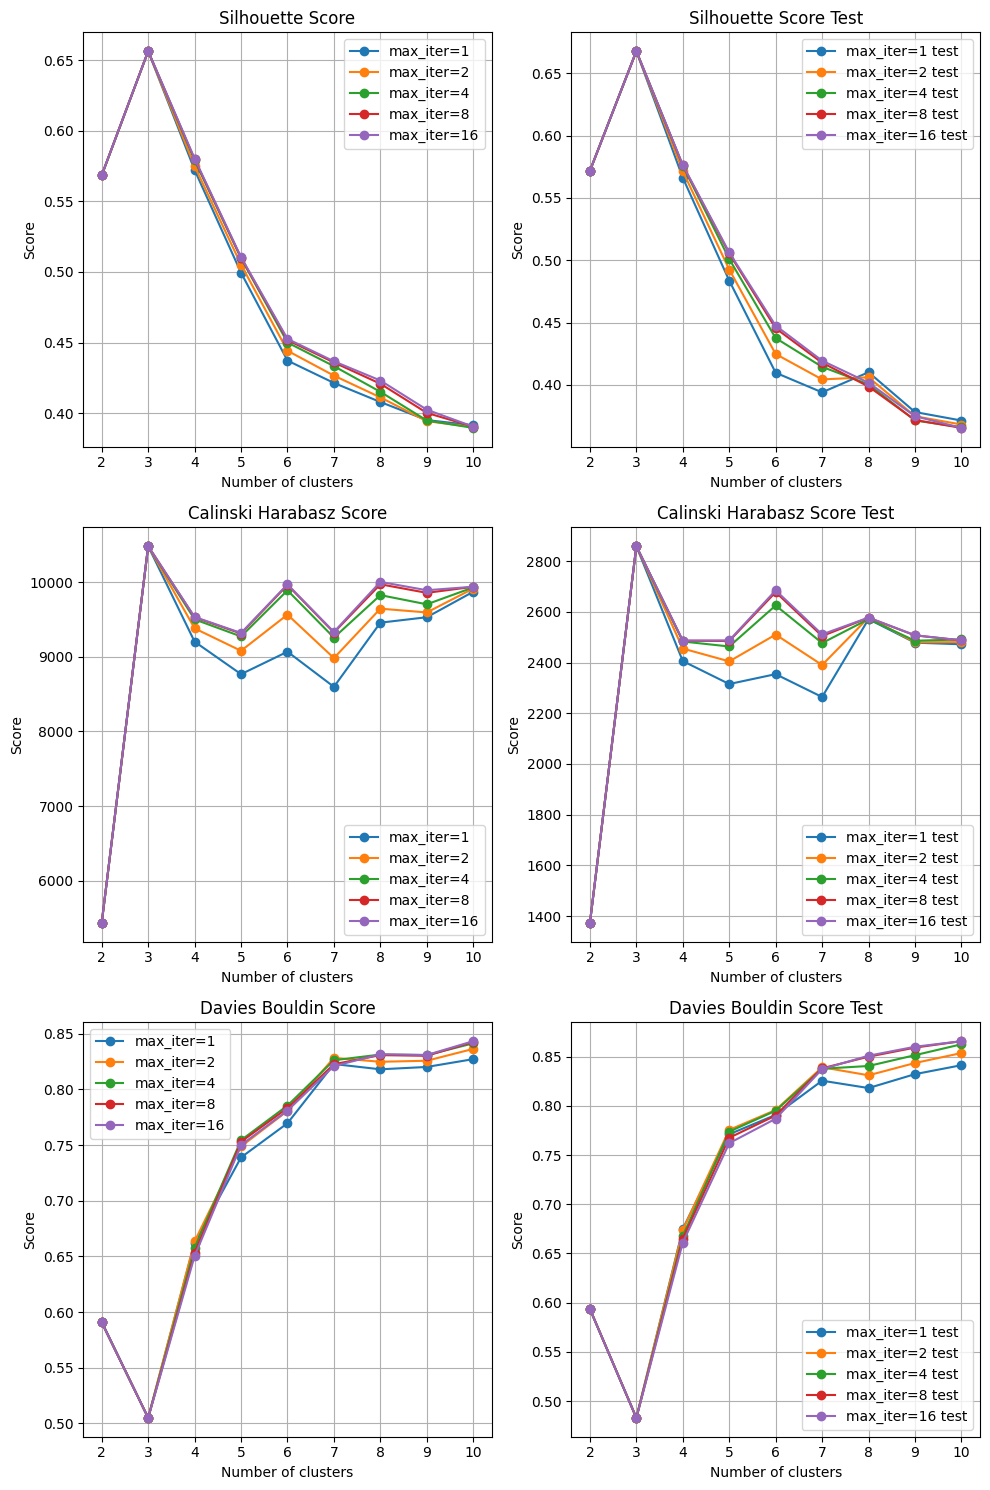

In [28]:
def test_kmeans_max_iter_hyperparameter(dataframe, test):
    max_iter_values = [1, 2, 4, 8, 16]

    silhouette_scores = {max_iter: [] for max_iter in max_iter_values}
    calinski_harabasz_scores = {max_iter: [] for max_iter in max_iter_values}
    davies_bouldin_scores = {max_iter: [] for max_iter in max_iter_values}

    silhouette_scores_test = {max_iter: [] for max_iter in max_iter_values}
    calinski_harabasz_scores_test = {max_iter: [] for max_iter in max_iter_values}
    davies_bouldin_scores_test = {max_iter: [] for max_iter in max_iter_values}

    for max_iter in max_iter_values:
        for n_clusters in range(2, 11):
            kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random)
            kmeans.fit(dataframe)
            y_kmeans = kmeans.predict(dataframe)
            y_test_kmeans = kmeans.predict(test)
            silhouette_scores[max_iter].append(silhouette_score(dataframe, y_kmeans))
            calinski_harabasz_scores[max_iter].append(
                calinski_harabasz_score(dataframe, y_kmeans)
            )
            davies_bouldin_scores[max_iter].append(
                davies_bouldin_score(dataframe, y_kmeans)
            )

            silhouette_scores_test[max_iter].append(silhouette_score(test, y_test_kmeans))
            calinski_harabasz_scores_test[max_iter].append(
                calinski_harabasz_score(test, y_test_kmeans)
            )
            davies_bouldin_scores_test[max_iter].append(
                davies_bouldin_score(test, y_test_kmeans)
            )

    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    for max_iter in max_iter_values:
        axs[0][0].plot(
            range(2, 11),
            silhouette_scores[max_iter],
            marker="o",
            label=f"max_iter={max_iter}",
        )
        axs[1][0].plot(
            range(2, 11),
            calinski_harabasz_scores[max_iter],
            marker="o",
            label=f"max_iter={max_iter}",
        )
        axs[2][0].plot(
            range(2, 11),
            davies_bouldin_scores[max_iter],
            marker="o",
            label=f"max_iter={max_iter}",
        )

    for max_iter in max_iter_values:
        axs[0][1].plot(
            range(2, 11),
            silhouette_scores_test[max_iter],
            marker="o",
            label=f"max_iter={max_iter} test",
        )
        axs[1][1].plot(
            range(2, 11),
            calinski_harabasz_scores_test[max_iter],
            marker="o",
            label=f"max_iter={max_iter} test",
        )
        axs[2][1].plot(
            range(2, 11),
            davies_bouldin_scores_test[max_iter],
            marker="o",
            label=f"max_iter={max_iter} test",
        )

    axs[0][0].set_title("Silhouette Score")
    axs[0][0].set_xlabel("Number of clusters")
    axs[0][0].set_ylabel("Score")
    axs[0][0].legend()
    axs[0][0].grid(True)

    axs[1][0].set_title("Calinski Harabasz Score")
    axs[1][0].set_xlabel("Number of clusters")
    axs[1][0].set_ylabel("Score")
    axs[1][0].legend()
    axs[1][0].grid(True)

    axs[2][0].set_title("Davies Bouldin Score")
    axs[2][0].set_xlabel("Number of clusters")
    axs[2][0].set_ylabel("Score")
    axs[2][0].legend()
    axs[2][0].grid(True)


    axs[0][1].set_title("Silhouette Score Test")
    axs[0][1].set_xlabel("Number of clusters")
    axs[0][1].set_ylabel("Score")
    axs[0][1].legend()
    axs[0][1].grid(True)

    axs[1][1].set_title("Calinski Harabasz Score Test")
    axs[1][1].set_xlabel("Number of clusters")
    axs[1][1].set_ylabel("Score")
    axs[1][1].legend()
    axs[1][1].grid(True)

    axs[2][1].set_title("Davies Bouldin Score Test")
    axs[2][1].set_xlabel("Number of clusters")
    axs[2][1].set_ylabel("Score")
    axs[2][1].legend()
    axs[2][1].grid(True)
    

    plt.tight_layout()
    plt.show()


# Call the function with the sample dataframe
test_kmeans_max_iter_hyperparameter(XY_train_n, XY_test_n)

### Tolerancja

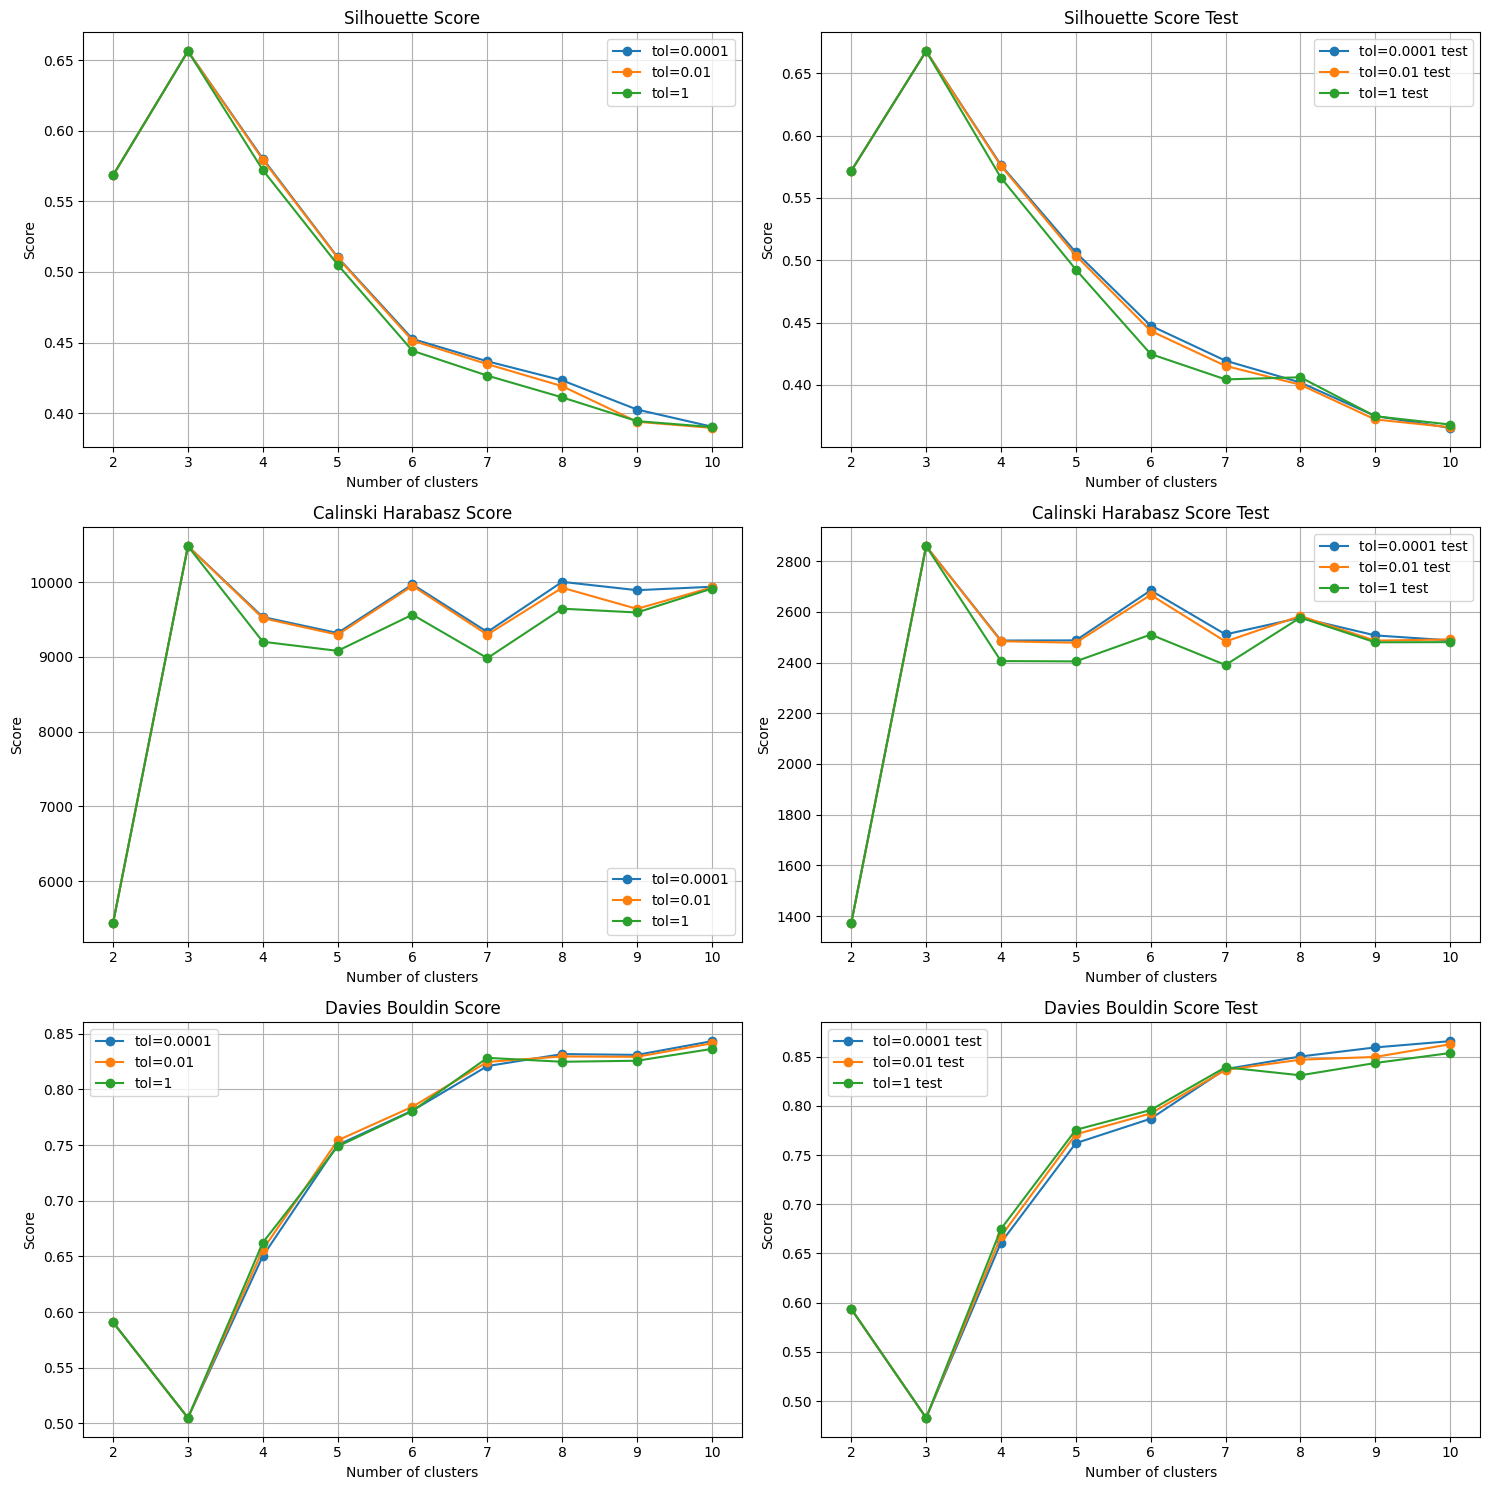

In [29]:
def test_kmeans_tol_hyperparameter(dataframe, test):
    tol_values = [1e-4, 1e-2, 1]

    silhouette_scores = {tol: [] for tol in tol_values}
    calinski_harabasz_scores = {tol: [] for tol in tol_values}
    davies_bouldin_scores = {tol: [] for tol in tol_values}

    silhouette_scores_test = {max_iter: [] for max_iter in tol_values}
    calinski_harabasz_scores_test = {max_iter: [] for max_iter in tol_values}
    davies_bouldin_scores_test = {max_iter: [] for max_iter in tol_values}

    for tol in tol_values:
        for n_clusters in range(2, 11):
            kmeans = KMeans(n_clusters=n_clusters, tol=tol, random_state=42)
            kmeans.fit(dataframe)
            y_kmeans = kmeans.predict(dataframe)
            y_test_kmeans = kmeans.predict(test)

            silhouette_scores[tol].append(silhouette_score(dataframe, y_kmeans))
            calinski_harabasz_scores[tol].append(
                calinski_harabasz_score(dataframe, y_kmeans)
            )
            davies_bouldin_scores[tol].append(davies_bouldin_score(dataframe, y_kmeans))

            silhouette_scores_test[tol].append(silhouette_score(test, y_test_kmeans))
            calinski_harabasz_scores_test[tol].append(
                calinski_harabasz_score(test, y_test_kmeans)
            )
            davies_bouldin_scores_test[tol].append(
                davies_bouldin_score(test, y_test_kmeans)
            )

    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    for tol in tol_values:
        axs[0][0].plot(
            range(2, 11), silhouette_scores[tol], marker="o", label=f"tol={tol}"
        )
        axs[1][0].plot(
            range(2, 11), calinski_harabasz_scores[tol], marker="o", label=f"tol={tol}"
        )
        axs[2][0].plot(
            range(2, 11), davies_bouldin_scores[tol], marker="o", label=f"tol={tol}"
        )

    for tol in tol_values:
        axs[0][1].plot(
            range(2, 11),
            silhouette_scores_test[tol],
            marker="o",
            label=f"tol={tol} test",
        )
        axs[1][1].plot(
            range(2, 11),
            calinski_harabasz_scores_test[tol],
            marker="o",
            label=f"tol={tol} test",
        )
        axs[2][1].plot(
            range(2, 11),
            davies_bouldin_scores_test[tol],
            marker="o",
            label=f"tol={tol} test",
        )

    axs[0][0].set_title("Silhouette Score")
    axs[0][0].set_xlabel("Number of clusters")
    axs[0][0].set_ylabel("Score")
    axs[0][0].legend()
    axs[0][0].grid(True)

    axs[1][0].set_title("Calinski Harabasz Score")
    axs[1][0].set_xlabel("Number of clusters")
    axs[1][0].set_ylabel("Score")
    axs[1][0].legend()
    axs[1][0].grid(True)

    axs[2][0].set_title("Davies Bouldin Score")
    axs[2][0].set_xlabel("Number of clusters")
    axs[2][0].set_ylabel("Score")
    axs[2][0].legend()
    axs[2][0].grid(True)

    axs[0][1].set_title("Silhouette Score Test")
    axs[0][1].set_xlabel("Number of clusters")
    axs[0][1].set_ylabel("Score")
    axs[0][1].legend()
    axs[0][1].grid(True)

    axs[1][1].set_title("Calinski Harabasz Score Test")
    axs[1][1].set_xlabel("Number of clusters")
    axs[1][1].set_ylabel("Score")
    axs[1][1].legend()
    axs[1][1].grid(True)

    axs[2][1].set_title("Davies Bouldin Score Test")
    axs[2][1].set_xlabel("Number of clusters")
    axs[2][1].set_ylabel("Score")
    axs[2][1].legend()
    axs[2][1].grid(True)

    plt.tight_layout()
    plt.show()


test_kmeans_tol_hyperparameter(XY_train_n, XY_test_n)

## DBSCAN  (Density-Based Spatial Clustering of Applications with Noise)
- jest popularnym algorytmem grupowania, który działa na zasadzie analizy gęstości przestrzennej punktów danych.
- DBSCAN ma dwie ważne parametry: epsilon (ε) i min_samples.
    - epsilon (ε) - promień okręgu wokół punktu, w którym szukamy innych punktów
    - min_samples - minimalna liczba punktów w promieniu epsilon, aby uznać punkt za rdzeniowy
- DBSCAN ma trzy rodzaje punktów:
    - punkty rdzeniowe - punkty, które mają co najmniej min_samples punktów w promieniu epsilon
    - punkty graniczne - punkty, które mają mniej niż min_samples punktów w promieniu epsilon, ale są w promieniu epsilon innego punktu rdzeniowego
    - punkty szumu - punkty, które nie są ani punktami rdzeniowymi ani punktami granicznymi
- Punkty szumowe są ignorowane lub mogą tworzyć osobny klaster dla szumu.
- DBSCAN potrafi radzić sobie z klastrami o nieregularnych kształtach, co jest wyzwaniem dla algorytmów opartych na odległościach, takich jak KMeans.



Jak określić wartości parametrów `eps` i `min_samples`?

- `eps` podobnie metoda łokcia dla dystansów między najbliższymi sąsiadami. Posortować po odległościach i wybrać punkt przegięcia.
- `min_samples` - zależy od wymiarów danych, >= 2 * liczba wymiarów. lub 1 + liczba wymiarów.

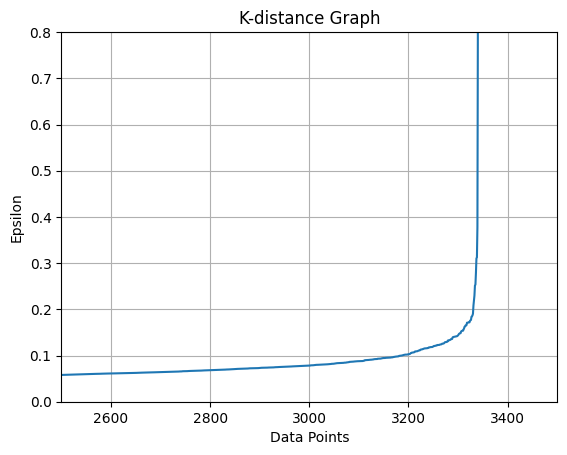

In [30]:
neighbours = NearestNeighbors(n_neighbors=10)
neighbours.fit(XY_train_n)
distances, indices = neighbours.kneighbors(XY_train_n)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim(0, 0.2)
plt.xlim(2500, 3500)
plt.yticks(np.arange(0, max(distances), 0.1))
plt.grid(True)
plt.title("K-distance Graph")
plt.xlabel("Data Points")
plt.ylabel("Epsilon")
plt.show()

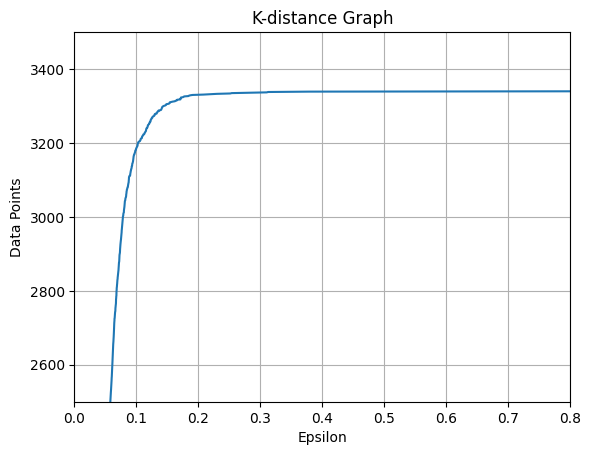

In [31]:
neighbours = NearestNeighbors(n_neighbors=10)
neighbours.fit(XY_train_n)
distances, indices = neighbours.kneighbors(XY_train_n)

# Sort distances and take the second column (nearest neighbor distance)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Plot with switched axes
plt.plot(distances, np.arange(len(distances)))
plt.xlim(0, 0.2)
plt.ylim(2500, 3500)
plt.xticks(np.arange(0, max(distances), 0.1))
plt.grid(True)
plt.title("K-distance Graph")
plt.ylabel("Data Points")
plt.xlabel("Epsilon")
plt.show()

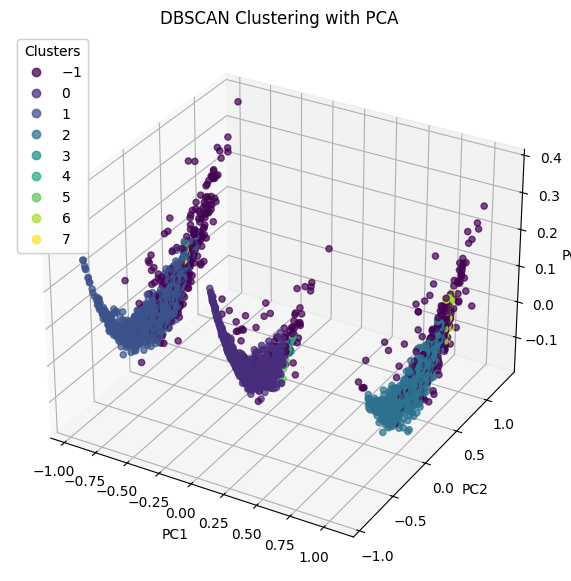

In [32]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.06, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_train_n)

# Reduce dimensions to 3 using PCA for visualization
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_n)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
scatter = ax.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    X_train_pca[:, 2],
    c=dbscan_labels,
    cmap="viridis",
    alpha=0.7,
)

# Add legend and labels
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("DBSCAN Clustering with PCA")

# Show plot
plt.show()

In [47]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan_labels = dbscan.fit_predict(XY_train_n)

# Reduce dimensions to 3 using PCA for visualization
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(XY_train_n)

# Create a DataFrame for Plotly
df = pd.DataFrame(X_train_pca, columns=["PC1", "PC2", "PC3"])
df["Cluster"] = dbscan_labels

# Create an interactive 3D plot using Plotly
fig = px.scatter_3d(
    df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Cluster",
    title="DBSCAN Clustering with eps = 0.1, min_samples = 10",
    labels={
        "PC1": "PC1",
        "PC2": "PC2",
        "PC3": "PC3",
    },
    width=1000,
    height=800,
    opacity=0.7,
)

# Show plot
fig.show()

In [42]:
# use pca to do dimension reduction
pca = PCA(n_components=3, random_state=random)
principalComponents = pca.fit_transform(X_train_n)

# Create a DataFrame with the principal components
principalDf3 = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2', 'pc3'])

# DBSCAN clustering
db_pca = DBSCAN(eps=0.1, min_samples=10)
db_pca.fit(X_train_n)
y_db_pca = db_pca.labels_

# Create a DataFrame with the cluster labels
df_clustered_pca = principalDf3.copy()
df_clustered_pca['Cluster'] = y_db_pca


fig = px.scatter_3d(
    df_clustered_pca,
    x="pc1",
    y="pc2",
    z="pc3",
    color=y_db_pca,
    opacity=0.7,
    width=1000,
    height=800,
)

# add fig title
fig.update_layout(title="DBSCAN Clustering eps=0.1 min_samples=10")

fig.show()

## Miary

### eps_values = np.linspace(0.01, 2.0, 10)

MovieWriter imagemagick unavailable; using Pillow instead.


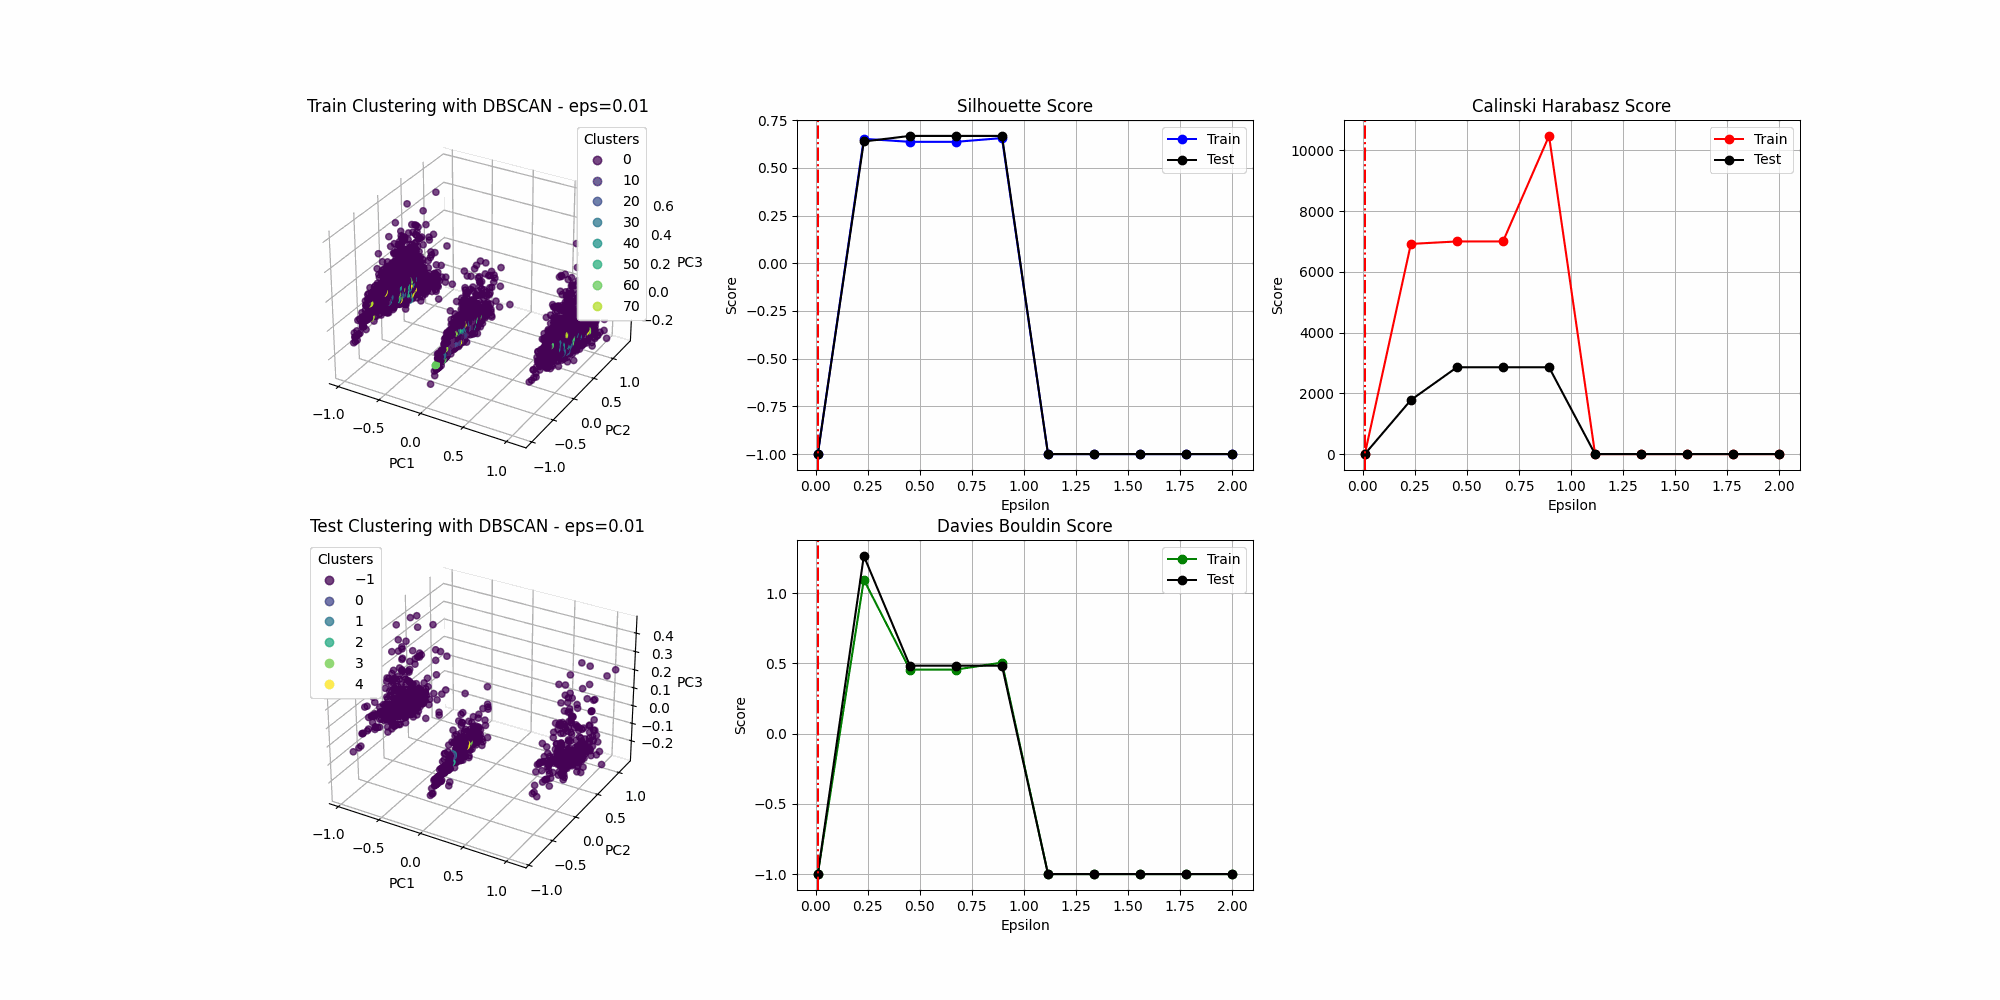

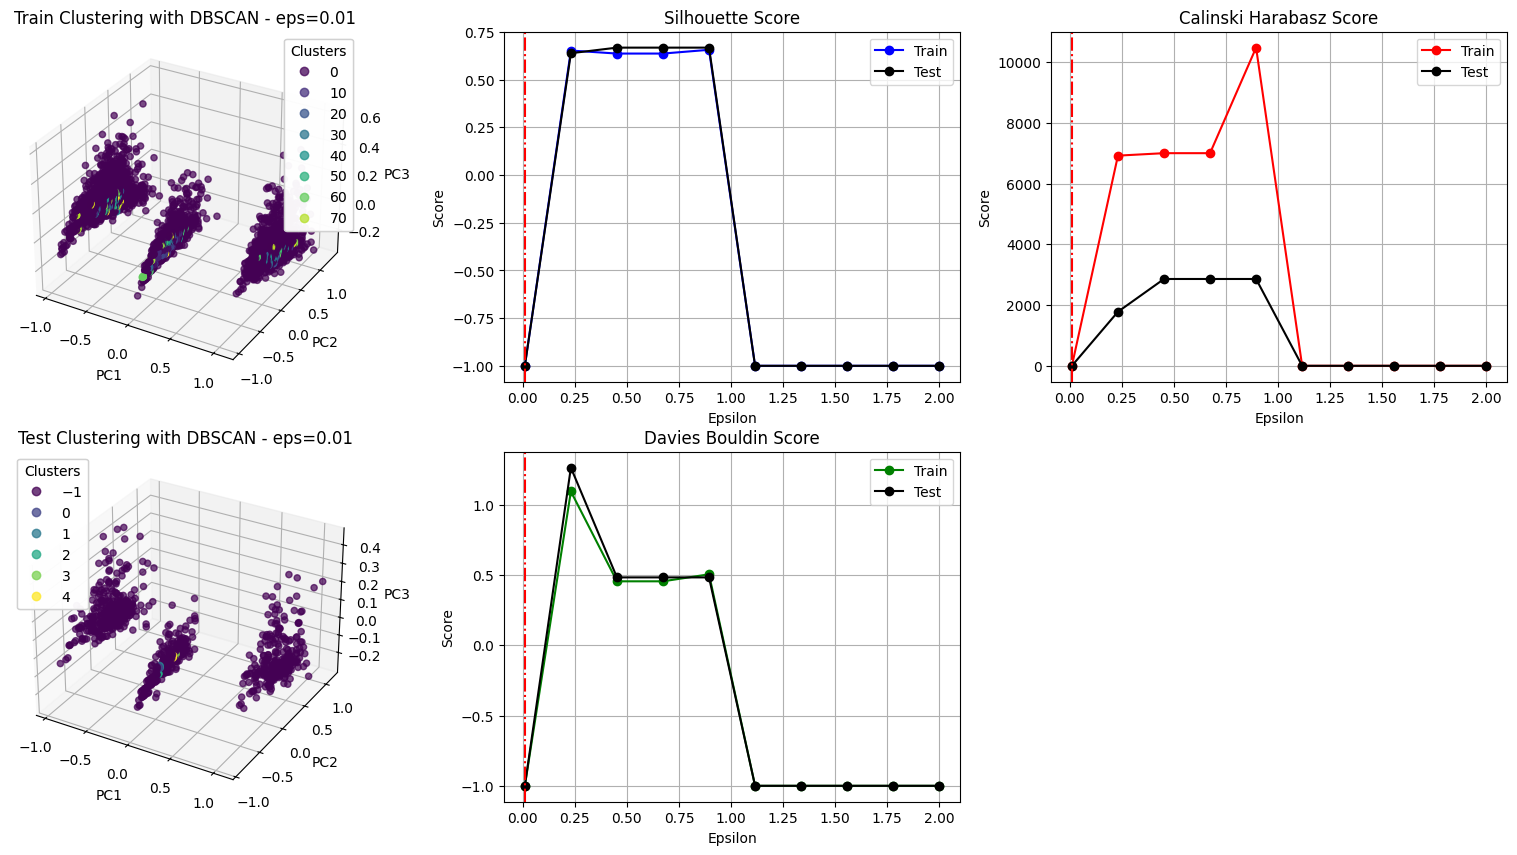

In [48]:
def animate_hiperparameters(dataframe, test, eps_values):
    # Perform PCA to reduce to 3 dimensions for visualization
    pca = PCA(n_components=3)
    principalDf3 = pd.DataFrame(
        pca.fit_transform(dataframe), columns=["PC1", "PC2", "PC3"]
    )
    pca_test = pd.DataFrame(pca.transform(test), columns=["PC1", "PC2", "PC3"])

    # Initialize lists to store metrics
    silhouette_scores_DBSCAN = []
    calinski_harabasz_scores_DBSCAN = []
    davies_bouldin_scores_DBSCAN = []

    silhouette_scores_DBSCAN_test = []
    calinski_harabasz_scores_DBSCAN_test = []
    davies_bouldin_scores_DBSCAN_test = []


    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=10)
        dbscan.fit(dataframe)
        y_dbscan = dbscan.labels_
        y_test_dbscan = dbscan.fit_predict(test)

        if len(set(y_dbscan)) > 1:
            silhouette_scores_DBSCAN.append(silhouette_score(dataframe, y_dbscan))
            calinski_harabasz_scores_DBSCAN.append(
                calinski_harabasz_score(dataframe, y_dbscan)
            )
            davies_bouldin_scores_DBSCAN.append(
                davies_bouldin_score(dataframe, y_dbscan)
            )
        else:
            silhouette_scores_DBSCAN.append(-1)
            calinski_harabasz_scores_DBSCAN.append(-1)
            davies_bouldin_scores_DBSCAN.append(-1)

        if len(set(y_test_dbscan)) > 1:
            silhouette_scores_DBSCAN_test.append(silhouette_score(test, y_test_dbscan))
            calinski_harabasz_scores_DBSCAN_test.append(
                calinski_harabasz_score(test, y_test_dbscan)
            )
            davies_bouldin_scores_DBSCAN_test.append(
                davies_bouldin_score(test, y_test_dbscan)
            )
        else:
            silhouette_scores_DBSCAN_test.append(-1)
            calinski_harabasz_scores_DBSCAN_test.append(-1)
            davies_bouldin_scores_DBSCAN_test.append(-1)

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(231, projection="3d")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")
    ax1.set_title("Train Clustering with PCA")

    ax2 = fig.add_subplot(234, projection="3d")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")
    ax2.set_title("Test Clustering with PCA")

    ax3 = fig.add_subplot(232)
    ax4 = fig.add_subplot(233)
    ax5 = fig.add_subplot(235)

    def update(frame):
        eps = eps_values[frame]
        ax1.cla()
        ax1.set_xlabel("PC1")
        ax1.set_ylabel("PC2")
        ax1.set_zlabel("PC3")
        ax1.set_title(f"Train Clustering with DBSCAN - eps={eps:.2f}")

        ax2.cla()
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")
        ax2.set_zlabel("PC3")
        ax2.set_title(f"Test Clustering with DBSCAN - eps={eps:.2f}")

        dbscan_pca = DBSCAN(eps=eps, min_samples=5)
        y_dbscan_pca = dbscan_pca.fit_predict(principalDf3)
        y_dbscan_pca_test = dbscan_pca.fit_predict(pca_test)

        df_clustered_pca = principalDf3.copy()
        df_clustered_pca["Cluster"] = y_dbscan_pca

        df_clustered_pca_test = pca_test.copy()
        df_clustered_pca_test["Cluster"] = y_dbscan_pca_test

        scatter1 = ax1.scatter(
            df_clustered_pca["PC1"],
            df_clustered_pca["PC2"],
            df_clustered_pca["PC3"],
            c=df_clustered_pca["Cluster"],
            cmap="viridis",
            alpha=0.7,
        )
        legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
        ax1.add_artist(legend1)

        scatter2 = ax2.scatter(
            df_clustered_pca_test["PC1"],
            df_clustered_pca_test["PC2"],
            df_clustered_pca_test["PC3"],
            c=df_clustered_pca_test["Cluster"],
            cmap="viridis",
            alpha=0.7,
        )
        legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
        ax2.add_artist(legend2)

        ax3.cla()
        ax4.cla()
        ax5.cla()

        ax3.plot(
            eps_values, silhouette_scores_DBSCAN, marker="o", color="b", label="Train"
        )
        ax3.plot(
            eps_values,
            silhouette_scores_DBSCAN_test,
            marker="o",
            color="k",
            label="Test",
        )
        ax3.set_title("Silhouette Score")
        ax3.set_xlabel("Epsilon")
        ax3.set_ylabel("Score")
        ax3.grid(True)
        ax3.axvline(x=eps, color="r", linestyle="-.")
        ax3.legend()

        ax4.plot(
            eps_values,
            calinski_harabasz_scores_DBSCAN,
            marker="o",
            color="r",
            label="Train",
        )
        ax4.plot(
            eps_values,
            calinski_harabasz_scores_DBSCAN_test,
            marker="o",
            color="k",
            label="Test",
        )
        ax4.set_title("Calinski Harabasz Score")
        ax4.set_xlabel("Epsilon")
        ax4.set_ylabel("Score")
        ax4.grid(True)
        ax4.axvline(x=eps, color="r", linestyle="-.")
        ax4.legend()

        ax5.plot(
            eps_values,
            davies_bouldin_scores_DBSCAN,
            marker="o",
            color="g",
            label="Train",
        )
        ax5.plot(
            eps_values,
            davies_bouldin_scores_DBSCAN_test,
            marker="o",
            color="k",
            label="Test",
        )
        ax5.set_title("Davies Bouldin Score")
        ax5.set_xlabel("Epsilon")
        ax5.set_ylabel("Score")
        ax5.grid(True)
        ax5.axvline(x=eps, color="r", linestyle="-.")
        ax5.legend()

    ani = animation.FuncAnimation(
        fig, update, frames=range(len(eps_values)), repeat=True
    )
    ani.save("dbscan_pca.gif", writer="imagemagick", fps=1)


eps_values = np.linspace(0.01, 2.0, 10)  # Epsilon values range
animate_hiperparameters(XY_train_n, XY_test_n, eps_values)
from IPython.display import Image

Image(filename="dbscan_pca.gif")

MovieWriter imagemagick unavailable; using Pillow instead.


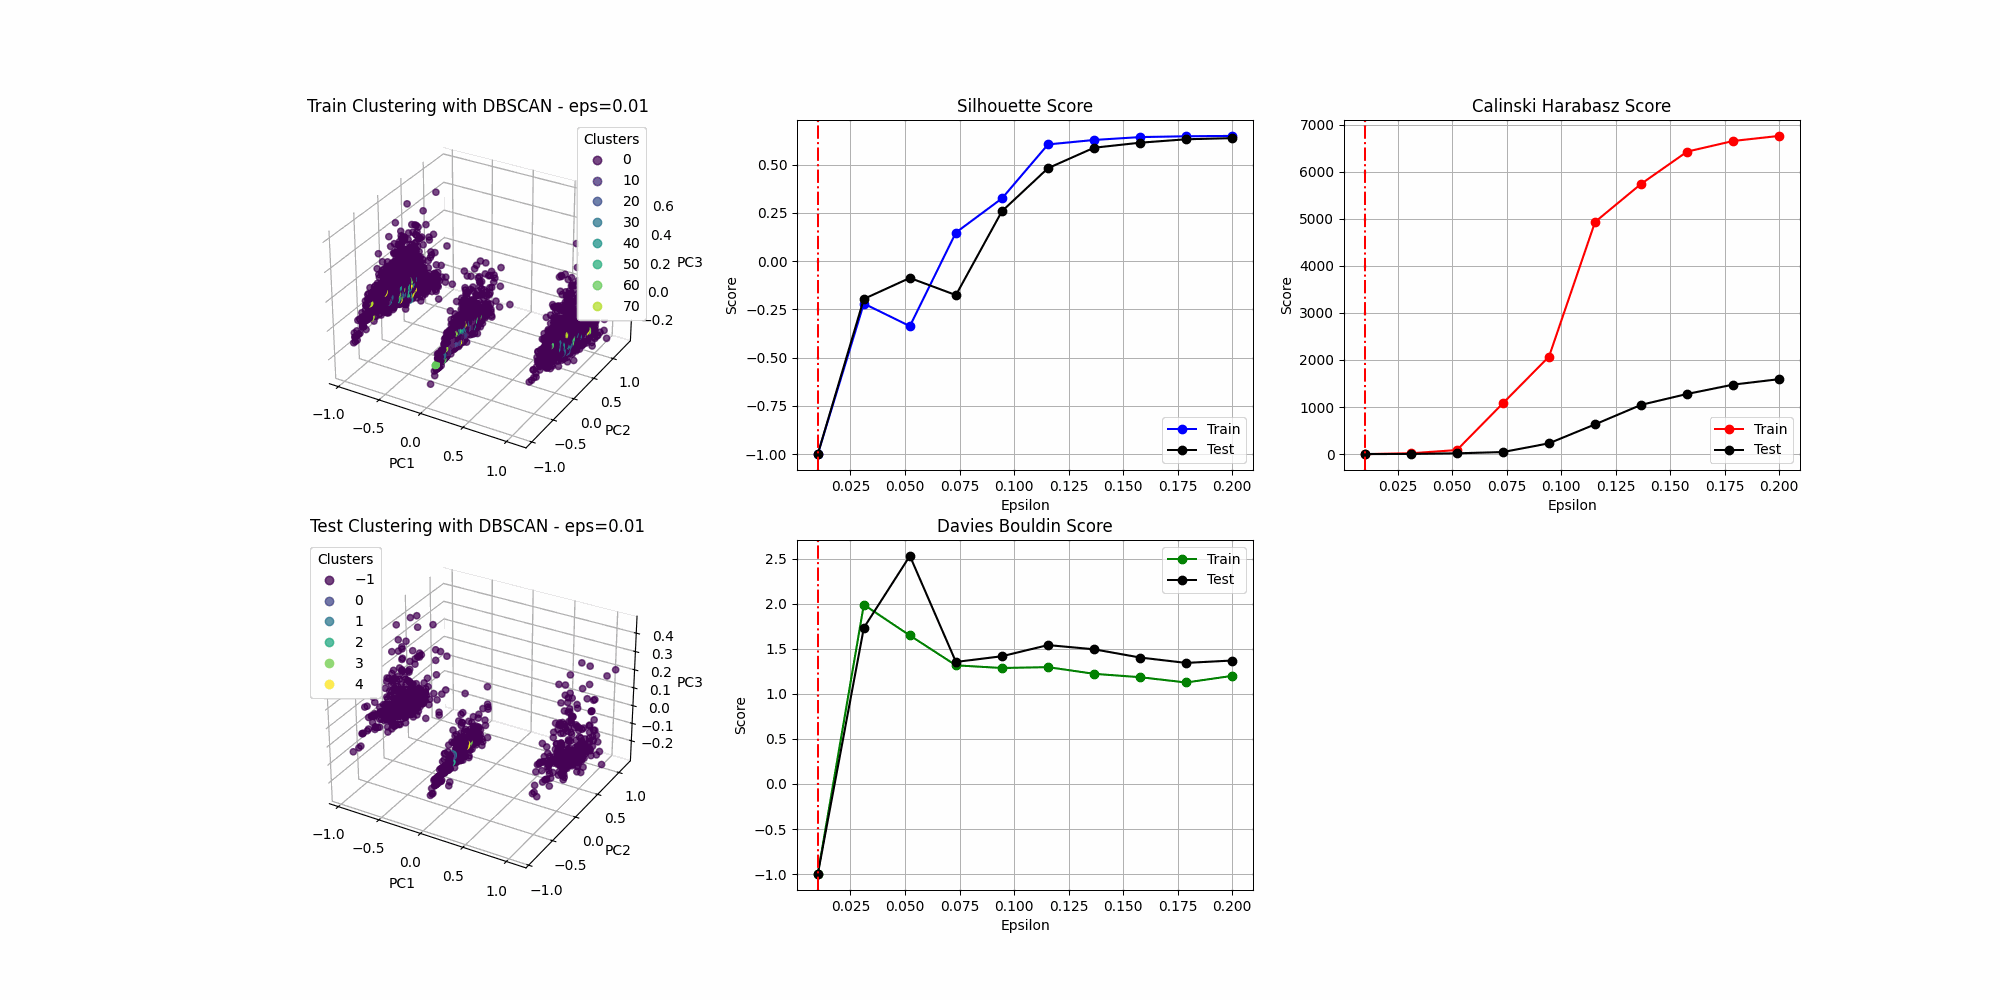

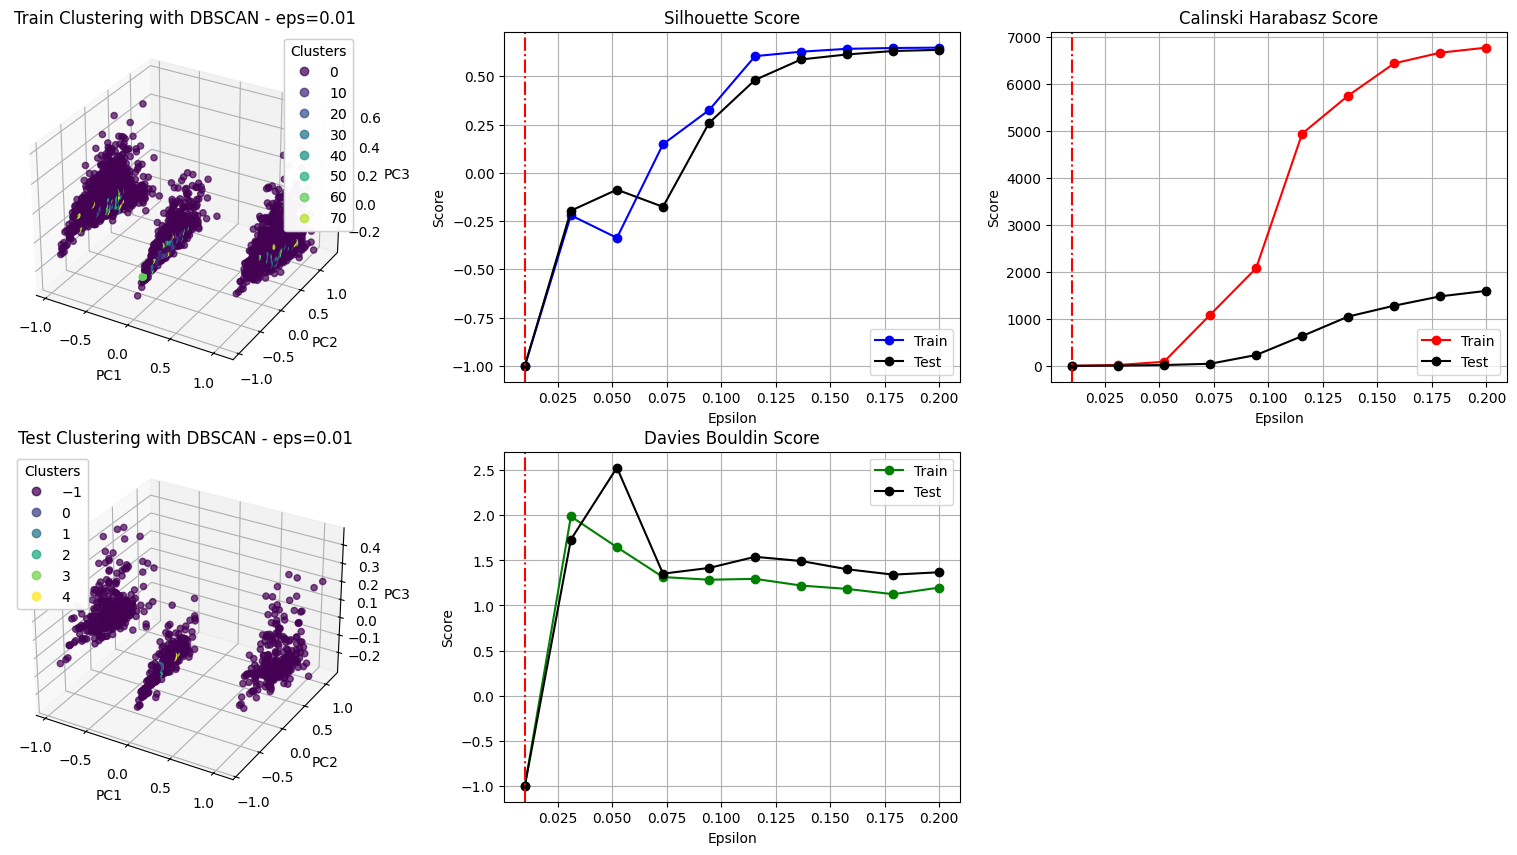

In [36]:
eps_values = np.linspace(0.01, 0.2, 10)  # Epsilon values range
animate_hiperparameters(XY_train_n, XY_test_n, eps_values)
from IPython.display import Image

Image(filename="dbscan_pca.gif")

### Min_samples = np.arange(1, 10)

MovieWriter Pillow unavailable; using Pillow instead.


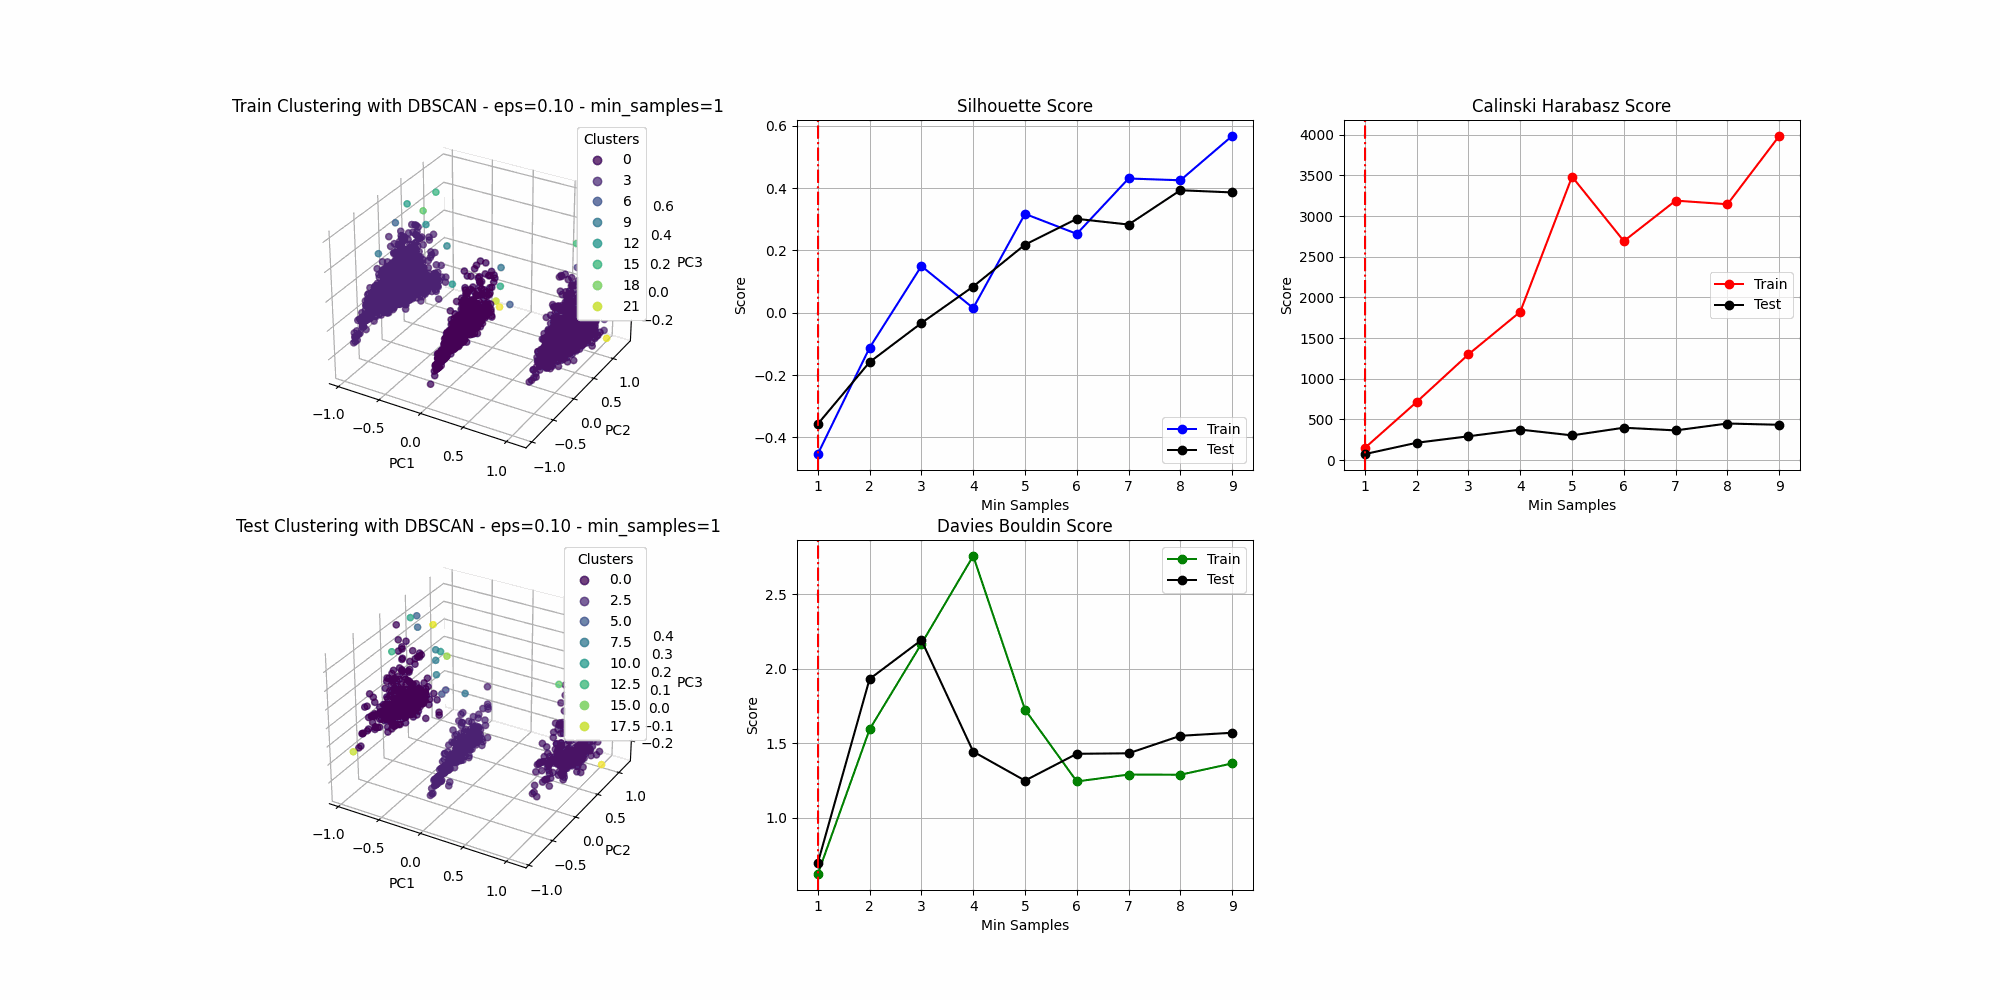

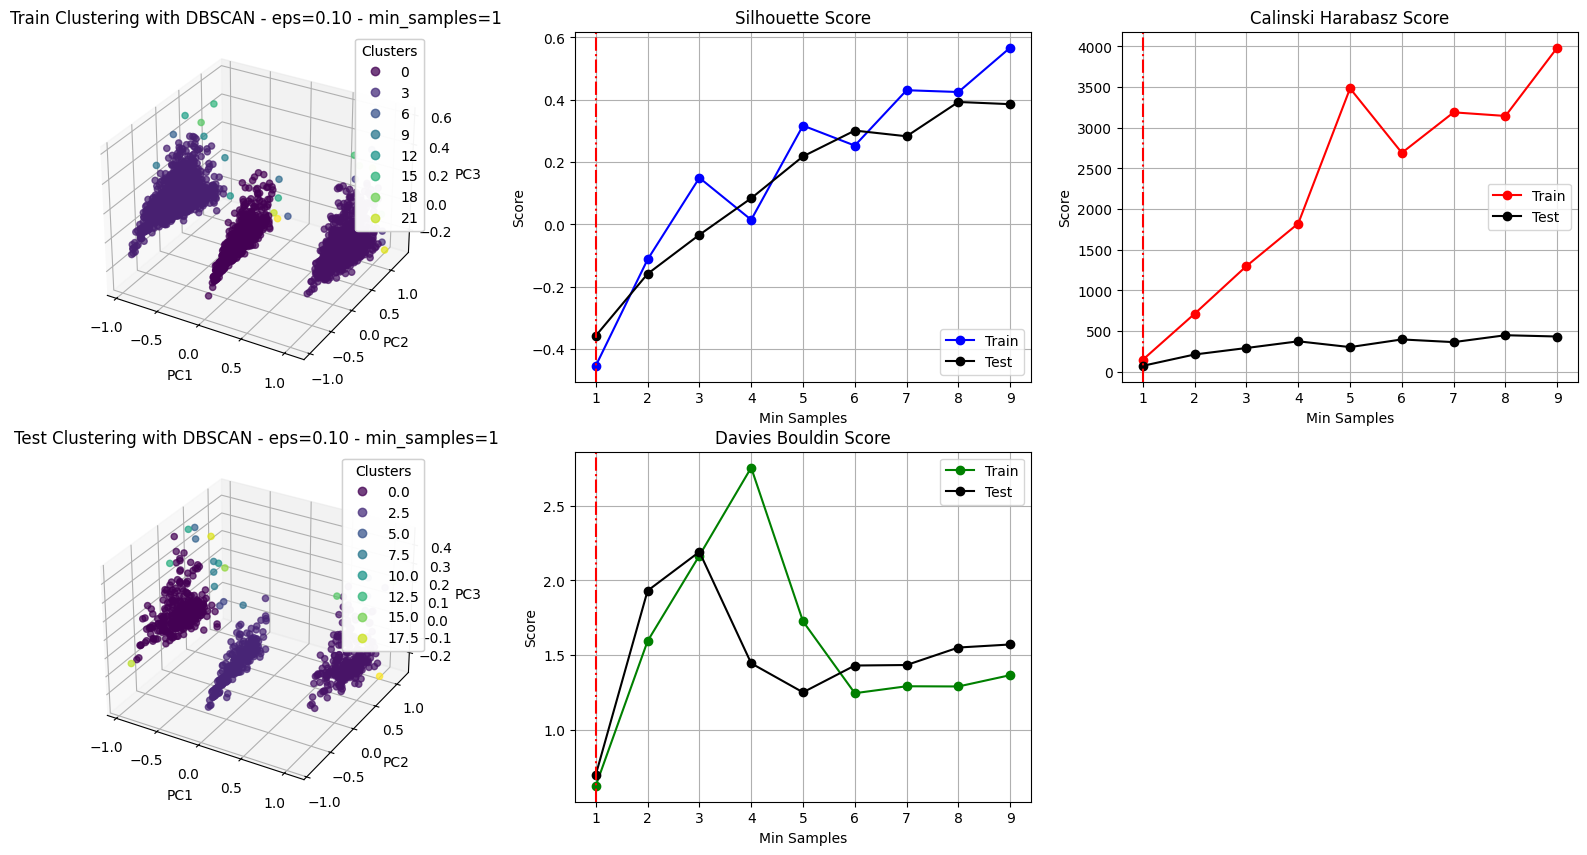

In [37]:
def animate_dbscan_hiperparameters_minsamples(dataframe, test, eps, min_samples_values):
    pca = PCA(n_components=3)
    principalDf3 = pd.DataFrame(
        pca.fit_transform(dataframe), columns=["PC1", "PC2", "PC3"]
    )
    pca_test = pd.DataFrame(pca.transform(test), columns=["PC1", "PC2", "PC3"])

    silhouette_scores_DBSCAN = []
    calinski_harabasz_scores_DBSCAN = []
    davies_bouldin_scores_DBSCAN = []

    silhouette_scores_DBSCAN_test = []
    calinski_harabasz_scores_DBSCAN_test = []
    davies_bouldin_scores_DBSCAN_test = []

    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(dataframe)
        y_dbscan = dbscan.labels_
        y_test_dbscan = dbscan.fit_predict(test)

        if len(set(y_dbscan)) > 1:
            silhouette_scores_DBSCAN.append(silhouette_score(dataframe, y_dbscan))
            calinski_harabasz_scores_DBSCAN.append(
                calinski_harabasz_score(dataframe, y_dbscan)
            )
            davies_bouldin_scores_DBSCAN.append(
                davies_bouldin_score(dataframe, y_dbscan)
            )
        else:
            silhouette_scores_DBSCAN.append(-1)
            calinski_harabasz_scores_DBSCAN.append(-1)
            davies_bouldin_scores_DBSCAN.append(-1)

        if len(set(y_test_dbscan)) > 1:
            silhouette_scores_DBSCAN_test.append(silhouette_score(test, y_test_dbscan))
            calinski_harabasz_scores_DBSCAN_test.append(
                calinski_harabasz_score(test, y_test_dbscan)
            )
            davies_bouldin_scores_DBSCAN_test.append(
                davies_bouldin_score(test, y_test_dbscan)
            )
        else:
            silhouette_scores_DBSCAN_test.append(-1)
            calinski_harabasz_scores_DBSCAN_test.append(-1)
            davies_bouldin_scores_DBSCAN_test.append(-1)

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(231, projection="3d")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")
    ax1.set_title("Train Clustering with PCA")

    ax2 = fig.add_subplot(234, projection="3d")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")
    ax2.set_title("Test Clustering with PCA")

    ax3 = fig.add_subplot(232)
    ax4 = fig.add_subplot(233)
    ax5 = fig.add_subplot(235)

    def update(frame):
        min_samples = min_samples_values[frame]
        ax1.cla()
        ax1.set_xlabel("PC1")
        ax1.set_ylabel("PC2")
        ax1.set_zlabel("PC3")
        ax1.set_title(
            f"Train Clustering with DBSCAN - eps={eps:.2f} - min_samples={min_samples}"
        )

        ax2.cla()
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")
        ax2.set_zlabel("PC3")
        ax2.set_title(
            f"Test Clustering with DBSCAN - eps={eps:.2f} - min_samples={min_samples}"
        )

        dbscan_pca = DBSCAN(eps=eps, min_samples=min_samples)
        y_dbscan_pca = dbscan_pca.fit_predict(principalDf3)
        y_dbscan_pca_test = dbscan_pca.fit_predict(pca_test)

        df_clustered_pca = principalDf3.copy()
        df_clustered_pca["Cluster"] = y_dbscan_pca

        df_clustered_pca_test = pca_test.copy()
        df_clustered_pca_test["Cluster"] = y_dbscan_pca_test

        scatter1 = ax1.scatter(
            df_clustered_pca["PC1"],
            df_clustered_pca["PC2"],
            df_clustered_pca["PC3"],
            c=df_clustered_pca["Cluster"],
            cmap="viridis",
            alpha=0.7,
        )
        legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
        ax1.add_artist(legend1)

        scatter2 = ax2.scatter(
            df_clustered_pca_test["PC1"],
            df_clustered_pca_test["PC2"],
            df_clustered_pca_test["PC3"],
            c=df_clustered_pca_test["Cluster"],
            cmap="viridis",
            alpha=0.7,
        )
        legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
        ax2.add_artist(legend2)

        ax3.cla()
        ax4.cla()
        ax5.cla()

        ax3.plot(
            min_samples_values,
            silhouette_scores_DBSCAN,
            marker="o",
            color="b",
            label="Train",
        )
        ax3.plot(
            min_samples_values,
            silhouette_scores_DBSCAN_test,
            marker="o",
            color="k",
            label="Test",
        )
        ax3.set_title("Silhouette Score")
        ax3.set_xlabel("Min Samples")
        ax3.set_ylabel("Score")
        ax3.grid(True)
        ax3.axvline(x=min_samples, color="r", linestyle="-.")
        ax3.legend()

        ax4.plot(
            min_samples_values,
            calinski_harabasz_scores_DBSCAN,
            marker="o",
            color="r",
            label="Train",
        )
        ax4.plot(
            min_samples_values,
            calinski_harabasz_scores_DBSCAN_test,
            marker="o",
            color="k",
            label="Test",
        )
        ax4.set_title("Calinski Harabasz Score")
        ax4.set_xlabel("Min Samples")
        ax4.set_ylabel("Score")
        ax4.grid(True)
        ax4.axvline(x=min_samples, color="r", linestyle="-.")
        ax4.legend()

        ax5.plot(
            min_samples_values,
            davies_bouldin_scores_DBSCAN,
            marker="o",
            color="g",
            label="Train",
        )
        ax5.plot(
            min_samples_values,
            davies_bouldin_scores_DBSCAN_test,
            marker="o",
            color="k",
            label="Test",
        )
        ax5.set_title("Davies Bouldin Score")
        ax5.set_xlabel("Min Samples")
        ax5.set_ylabel("Score")
        ax5.grid(True)
        ax5.axvline(x=min_samples, color="r", linestyle="-.")
        ax5.legend()

    ani = animation.FuncAnimation(
        fig, update, frames=range(len(min_samples_values)), repeat=True
    )
    ani.save("dbscan_min_samples.gif", writer="Pillow", fps=1)

min_samples_values = range(1, 10)
eps = 0.1
animate_dbscan_hiperparameters_minsamples(
    XY_train_n, XY_test_n, eps, min_samples_values
)
Image(filename="dbscan_min_samples.gif")

 Pytania Pomocnicze
 1. Czy przy grupowaniu potrzebna jest normalizacja/standaryzacja danych?
 2. Co różni oba algorytmy z punktu widzenia reprezentacji klastra?
 3. Który z algorytmów jest mniej odporny na szum i wartości odstające (ang. outliers)? Dlaczego?
 4. Czy w zadaniu grupowania powinniśmy użyć walidacji krzyżowej?
 5. Czy wyniki badanych algorytmów klasteryzacji powinny być powtarzane i uśredniane?
 6. Co mierzą miary klasteryzacji podane w treści zdania?
 7. Jak algorytmy zachowują się dla skrajnych wartości ilości klastrów?